# Assignment : Regression

 
In this notebook:

1. I will first explore the dataset provided
2. I will create models to predict the hourly bike rental demand. 
3. I will also make predictions for hourly demand in the test set which I submit in the solution_checker.xlsx file to generate rmsle score. 

Let's start by importing the libraries that I will be using.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
%matplotlib inline

# to automate many of our engineering processes
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.wrappers import SklearnTransformerWrapper


# scaler
from sklearn.preprocessing import StandardScaler

# model
from sklearn.linear_model import (
        LinearRegression,
        Ridge,
        Lasso
    )
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

# evaluation matrices
from sklearn.metrics import r2_score

# pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

# for neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

import optuna # for hyperparameter tunning
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Set plot style
sns.set(color_codes=True)
pd.set_option('display.max_columns', None)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# loadind the data
path_train = r'D:\capstone_projects\machine-learning-capstone-projects\regression\bike-sharing-assignment\data\train.csv'
path_test = r'D:\capstone_projects\machine-learning-capstone-projects\regression\bike-sharing-assignment\data\test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [4]:
# first five rows
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81.0,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80.0,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80.0,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75.0,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75.0,0.0,0,1,1


In [5]:
# last five rows 
df_train.tail()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
12975,2012-06-29 20:00:00,3,0,1,1,37.72,44.695,42.0,16.9979,53,255,308
12976,2012-06-29 21:00:00,3,0,1,2,35.26,41.665,53.0,12.9980,41,195,236
12977,2012-06-29 22:00:00,3,0,1,3,33.62,41.665,63.0,12.9980,34,129,163
12978,2012-06-29 23:00:00,3,0,1,3,33.62,41.665,63.0,12.9980,6,42,48
12979,2012-06-30 0:00:00,3,0,0,3,26.24,28.790,89.0,11.0014,4,65,69


In [6]:
# first five rows of test dataset
df_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered
0,2012-06-30 1:00:00,3,0,0,3,26.24,28.790,89.0,15.0013,3,55
1,2012-06-30 2:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,7,54
2,2012-06-30 3:00:00,3,0,0,2,26.24,28.790,89.0,0.0000,3,20
3,2012-06-30 4:00:00,3,0,0,2,25.42,27.275,94.0,0.0000,3,15
4,2012-06-30 5:00:00,3,0,0,1,26.24,28.790,89.0,11.0014,3,7


In [7]:
# info of the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    12980 non-null  object 
 1   season      12980 non-null  int64  
 2   holiday     12980 non-null  int64  
 3   workingday  12980 non-null  int64  
 4   weather     12980 non-null  int64  
 5   temp        12980 non-null  float64
 6   atemp       12980 non-null  float64
 7   humidity    12980 non-null  float64
 8   windspeed   12980 non-null  float64
 9   casual      12980 non-null  int64  
 10  registered  12980 non-null  int64  
 11  count       12980 non-null  int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 1.2+ MB


In [8]:
# checking the duplicated records
df_train.duplicated().sum()

0

In [9]:
# checking the null values in each columns
df_train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Creating new features from datetime columns

In [10]:
# df_train
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_train['year'] = df_train['datetime'].dt.year
df_train['month'] = df_train['datetime'].dt.month
df_train['day'] = df_train['datetime'].dt.day
df_train['hour'] = df_train['datetime'].dt.hour

# df_test
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = df_test['datetime'].dt.year
df_test['month'] = df_test['datetime'].dt.month
df_test['day'] = df_test['datetime'].dt.day
df_test['hour'] = df_test['datetime'].dt.hour

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12980 entries, 0 to 12979
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    12980 non-null  datetime64[ns]
 1   season      12980 non-null  int64         
 2   holiday     12980 non-null  int64         
 3   workingday  12980 non-null  int64         
 4   weather     12980 non-null  int64         
 5   temp        12980 non-null  float64       
 6   atemp       12980 non-null  float64       
 7   humidity    12980 non-null  float64       
 8   windspeed   12980 non-null  float64       
 9   casual      12980 non-null  int64         
 10  registered  12980 non-null  int64         
 11  count       12980 non-null  int64         
 12  year        12980 non-null  int32         
 13  month       12980 non-null  int32         
 14  day         12980 non-null  int32         
 15  hour        12980 non-null  int32         
dtypes: datetime64[ns](1), 

In [11]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4399 entries, 0 to 4398
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    4399 non-null   datetime64[ns]
 1   season      4399 non-null   int64         
 2   holiday     4399 non-null   int64         
 3   workingday  4399 non-null   int64         
 4   weather     4399 non-null   int64         
 5   temp        4399 non-null   float64       
 6   atemp       4399 non-null   float64       
 7   humidity    4399 non-null   float64       
 8   windspeed   4399 non-null   float64       
 9   casual      4399 non-null   int64         
 10  registered  4399 non-null   int64         
 11  year        4399 non-null   int32         
 12  month       4399 non-null   int32         
 13  day         4399 non-null   int32         
 14  hour        4399 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(4), int64(6)
memory usage: 446.9

In [12]:
# Is `count` addition of `casual` and `registered`
(~(df_train['casual'] + df_train['registered'] == df_train['count'])).sum()

0

The target `count` is created from addition of `casual` and `registered`. So, these two columns cannot be the features.

In [13]:
# dropping 'casual' and 'registered'
df_train.drop(['casual', 'registered'], axis=1, inplace=True)
df_test.drop(['casual', 'registered'], axis=1, inplace=True)
df_train.columns.sort_values()

Index(['atemp', 'count', 'datetime', 'day', 'holiday', 'hour', 'humidity',
       'month', 'season', 'temp', 'weather', 'windspeed', 'workingday',
       'year'],
      dtype='object')

In [14]:
df_test.columns.sort_values()

Index(['atemp', 'datetime', 'day', 'holiday', 'hour', 'humidity', 'month',
       'season', 'temp', 'weather', 'windspeed', 'workingday', 'year'],
      dtype='object')

In [15]:
# Are there any working days on holidays
df_train.loc[(df_train['holiday'] == df_train['workingday']), ['holiday', 'workingday']].describe()

,holiday,workingday
count,3719.0,3719.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


## maping `season` column

In [16]:
season_map = {1:'spring', 2:'summer', 3:'fall', 4:'winter'}

df_train['season'] = df_train['season'].map(season_map)
df_test['season'] = df_test['season'].map(season_map)

df_train.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,spring,0,0,1,9.84,14.395,81.0,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,spring,0,0,1,9.02,13.635,80.0,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,spring,0,0,1,9.02,13.635,80.0,0.0,32,2011,1,1,2


In [17]:
df_test.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
0,2012-06-30 01:00:00,fall,0,0,3,26.24,28.79,89.0,15.0013,2012,6,30,1
1,2012-06-30 02:00:00,fall,0,0,2,26.24,28.79,89.0,0.0000,2012,6,30,2
2,2012-06-30 03:00:00,fall,0,0,2,26.24,28.79,89.0,0.0000,2012,6,30,3


## EDA

In [18]:
df_train.describe(include=np.number)

,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,hour
count,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000,12980.000000
mean,0.027504,0.685978,1.426656,19.725422,23.112436,62.358552,13.141760,167.577812,2011.333975,5.543914,15.645532,11.554545
std,0.163553,0.464143,0.647955,7.828902,8.552046,19.963696,8.325987,160.758887,0.471649,3.303415,8.771527,6.911950
min,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,13.120000,15.910000,47.000000,7.001500,35.000000,2011.000000,3.000000,8.000000,6.000000
50%,0.000000,1.000000,1.000000,19.680000,23.485000,62.000000,12.998000,124.000000,2011.000000,5.000000,16.000000,12.000000
75%,0.000000,1.000000,2.000000,26.240000,30.305000,79.000000,19.001200,245.000000,2012.000000,8.000000,23.000000,18.000000
max,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,56.996900,957.000000,2012.000000,12.000000,31.000000,23.000000


### Pandas Profile Report

In [19]:
# profile = ProfileReport(df_train, explorative=True)
# profile.to_file('EDA report.html')

### Visualising target

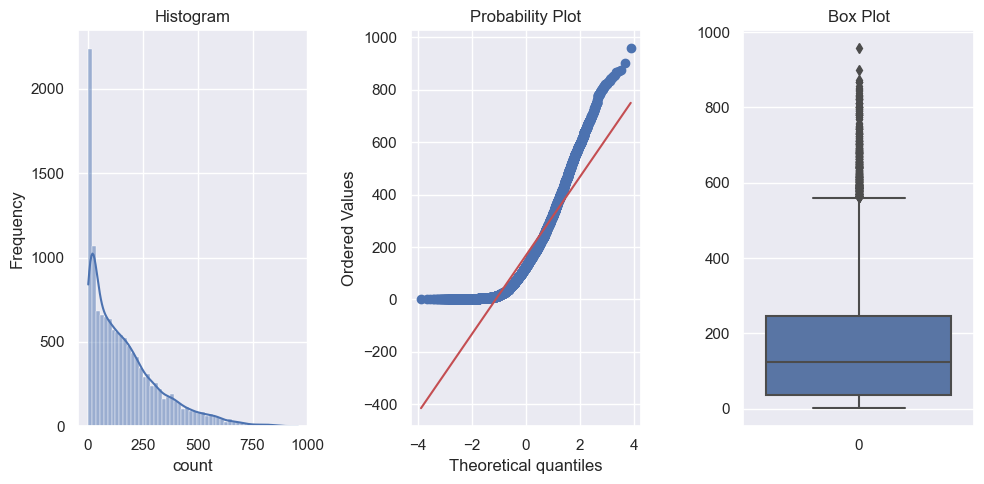

In [20]:
data = df_train['count']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

The distribution is right skewed. So, the transformation like log or square-root can be applied on linear regression, ridge, or lasso model.

In [21]:
df_train['count'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])

count    12980.000000
mean       167.577812
std        160.758887
min          1.000000
1%           1.000000
25%         35.000000
50%        124.000000
75%        245.000000
99%        678.000000
max        957.000000
Name: count, dtype: float64

std 1.4838, skew-0.9400


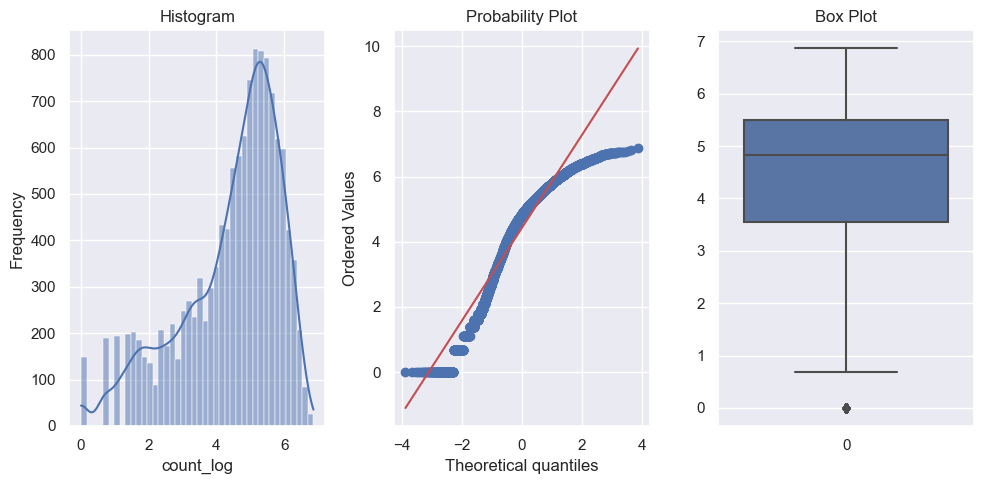

In [22]:
data = pd.Series(np.log(df_train['count']), name='count_log')

print(f'std{data.std(): .4f}, skew{data.skew(): .4f}')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

std 6.3115, skew 0.2951


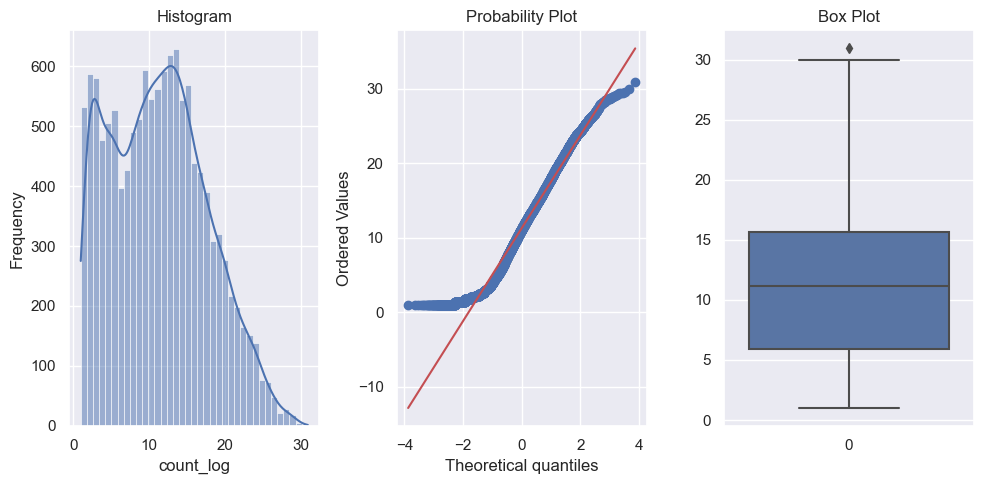

In [23]:
data = pd.Series(np.sqrt(df_train['count']), name='count_log')
print(f'std{data.std(): .4f}, skew{data.skew(): .4f}')
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

### Univariate analysis on numerical variable

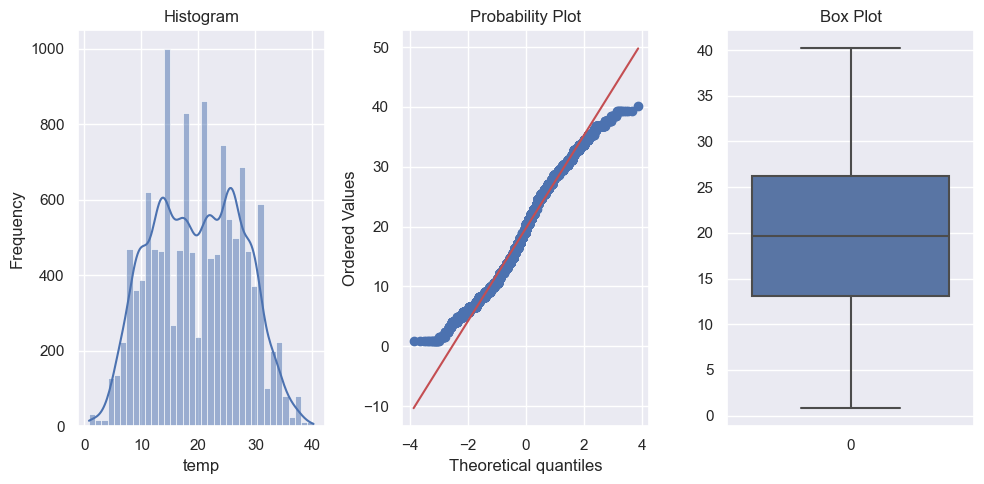

In [24]:
data = df_train['temp']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

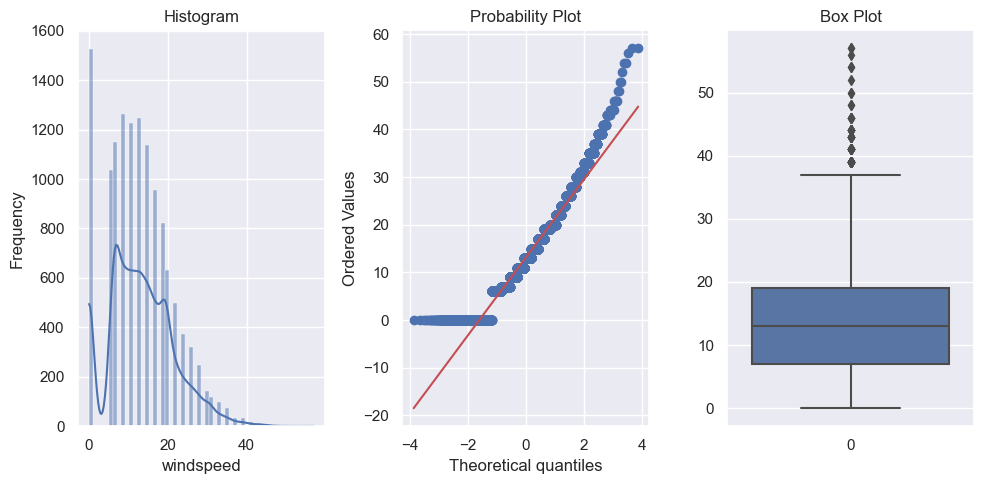

In [25]:
data = df_train['windspeed']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

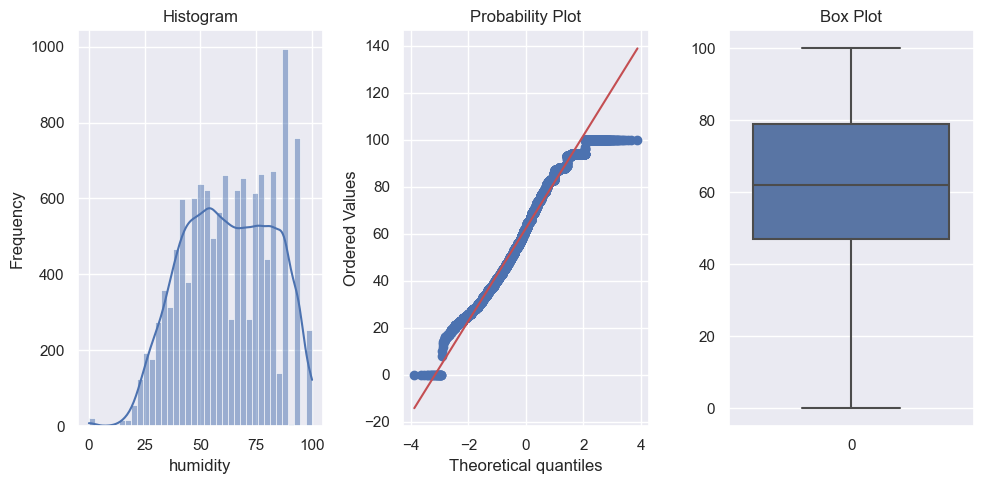

In [26]:
data = df_train['humidity']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
sns.histplot(data=data,kde=True, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_ylabel('Frequency')

stats.probplot(data, plot=axes[1])

sns.boxplot(data, ax=axes[2])
axes[2].set_title('Box Plot')

plt.tight_layout()
plt.show()

### Univariate analysis on Categorical variable

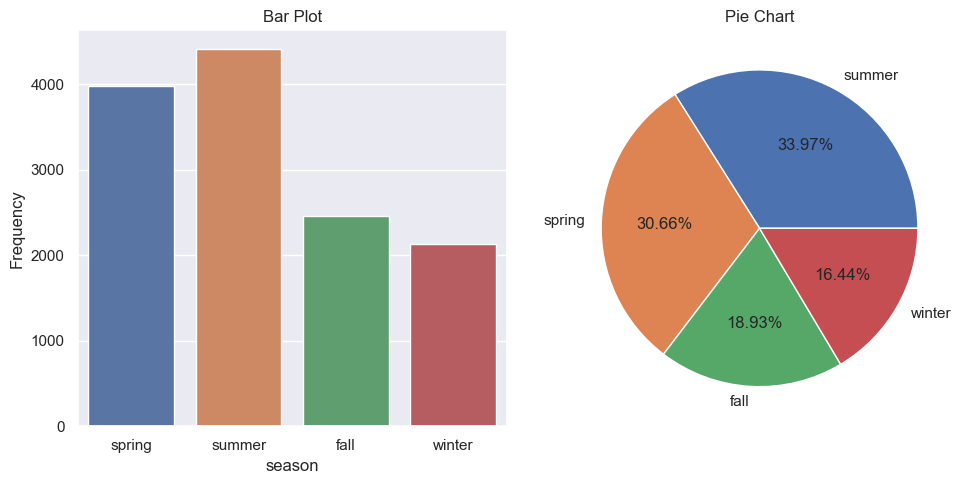

In [27]:
data = df_train['season']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

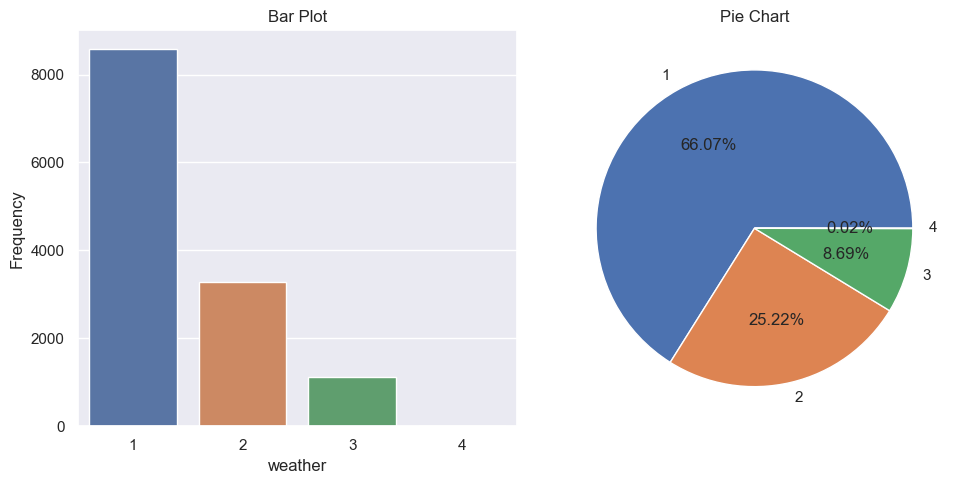

In [28]:
data = df_train['weather']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

In [29]:
df_train['weather'].value_counts()

weather
1    8576
2    3273
3    1128
4       3
Name: count, dtype: int64

In [30]:
df_test['weather'].value_counts()

weather
1    2837
2    1271
3     291
Name: count, dtype: int64

We can see that there are only 3 records correspond to `weather 4` (i.e. worst weather) in the train dataset and it does not present in the test dataset. So, we can replace it with 3.

In [31]:
df_train.loc[df_train['weather']==4, 'weather'] = 3
df_test.loc[df_test['weather']==4, 'weather'] = 3

df_train['weather'].value_counts()

weather
1    8576
2    3273
3    1131
Name: count, dtype: int64

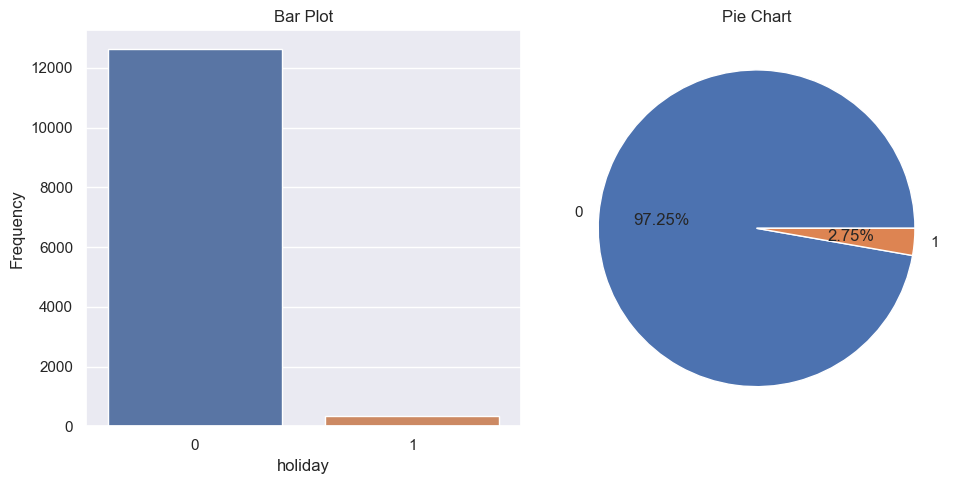

In [32]:
data = df_train['holiday']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

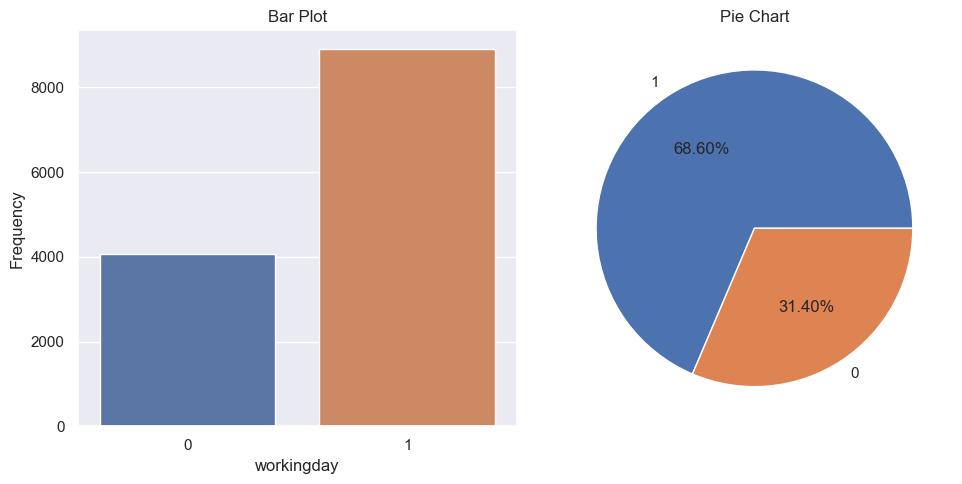

In [33]:
data = df_train['workingday']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

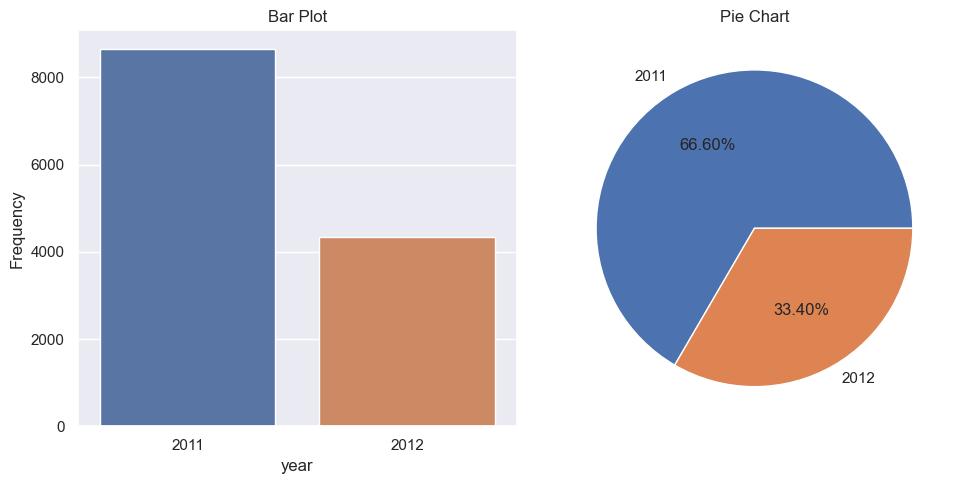

In [34]:
data = df_train['year']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

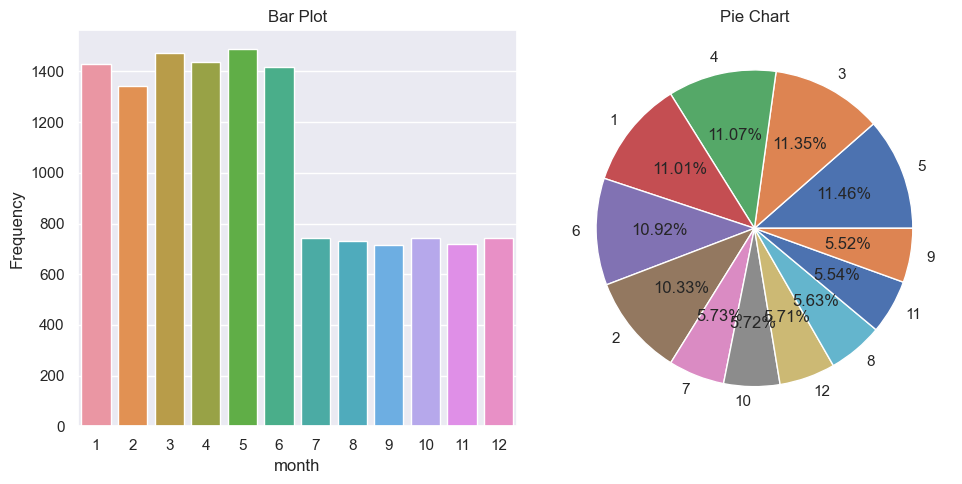

In [35]:
data = df_train['month']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot -1 Barplot
sns.countplot(x=data, ax=axes[0])
axes[0].set_title('Bar Plot')
axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
axes[1].pie(data.value_counts(), labels=data.value_counts().index, autopct='%0.2f%%')
axes[1].set_title('Pie Chart')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

### Bivariate Analysis

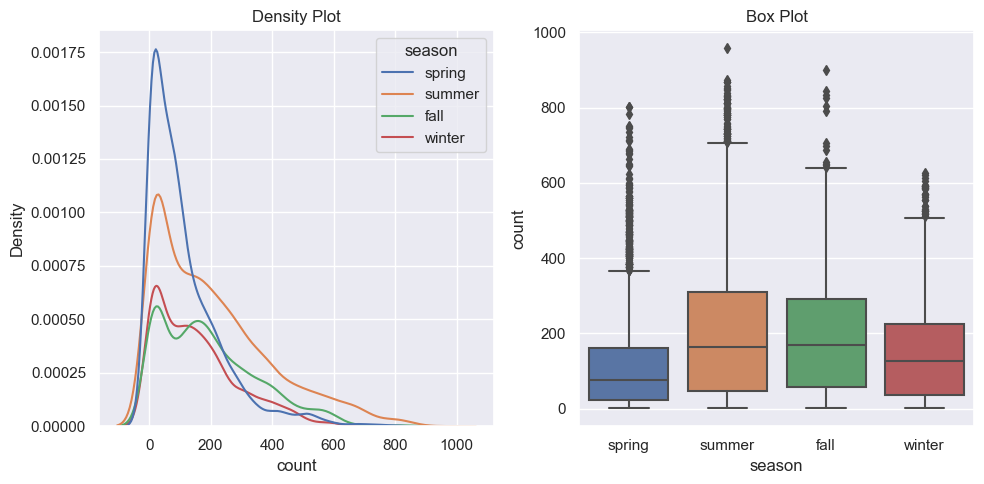

In [36]:
data = df_train['season']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

**comments**

* On average, bike rentals per hour are higher in `summer` and `fall` as compare to `spring` and `winter` season.

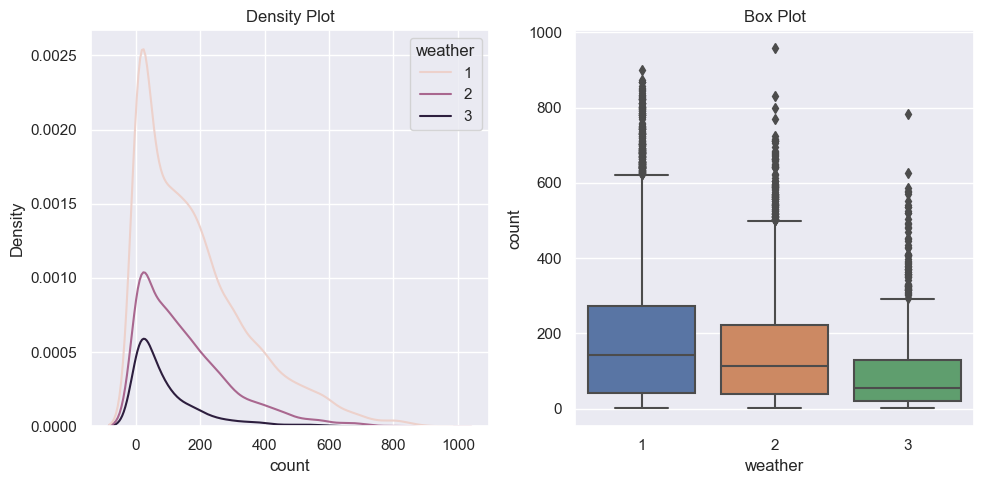

In [37]:
data = df_train['weather']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

**Comments**
* On average, bike rentals per hour are higher when `weather` is clean

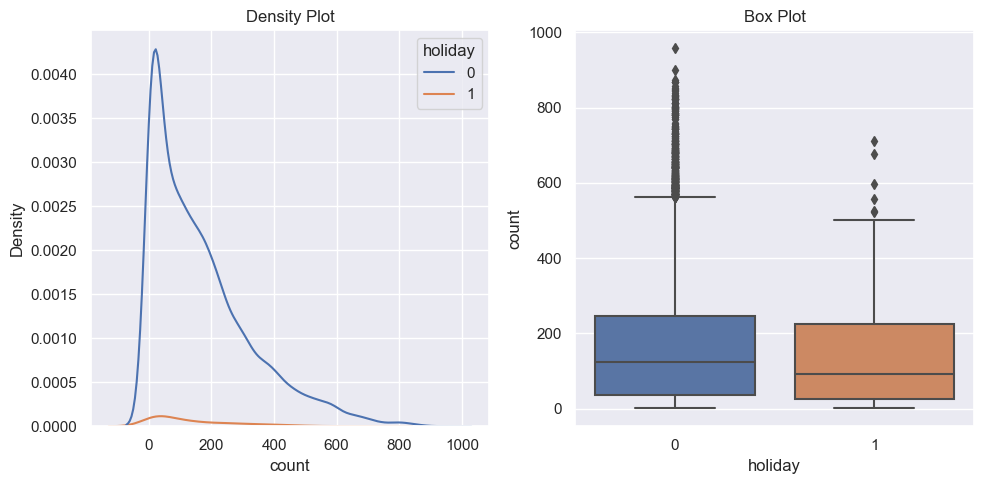

In [38]:
data = df_train['holiday']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

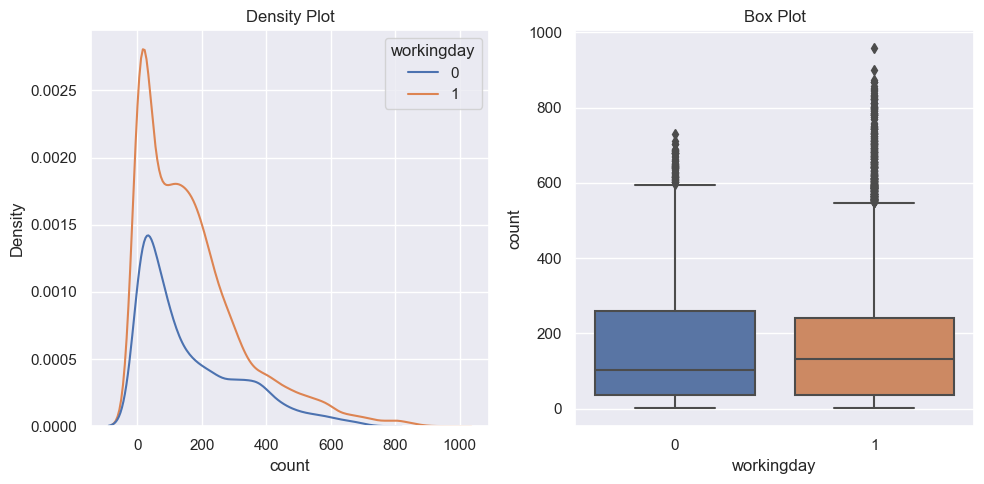

In [39]:
data = df_train['workingday']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

**Comments**
* The distribution of bike rentals per hour for `holiday` and `workingday` is almost same if we ignore the outlers

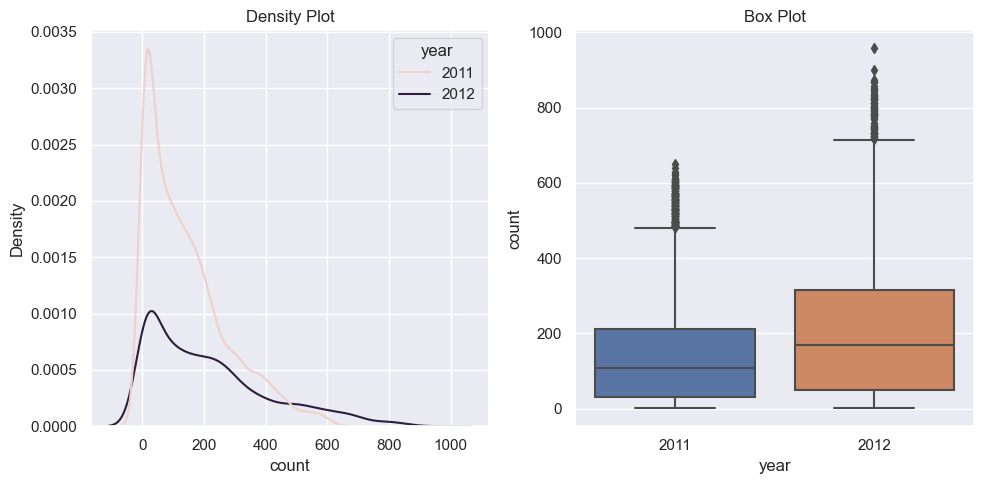

In [40]:
data = df_train['year']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

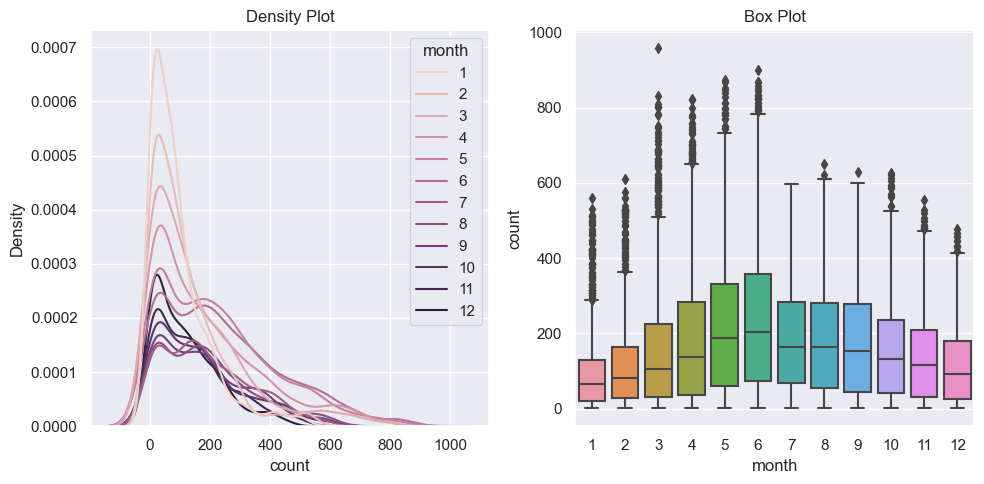

In [41]:
data = df_train['month']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

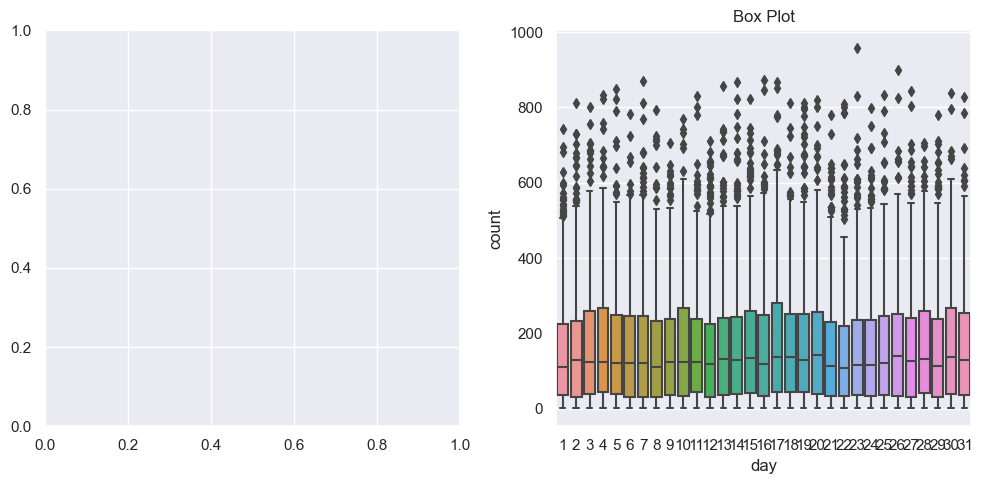

In [42]:
data = df_train['day']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot - 1: Density Plot
# sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
# axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes[1].set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

Text(0, 0.5, 'No. of Bike rented per Hour')

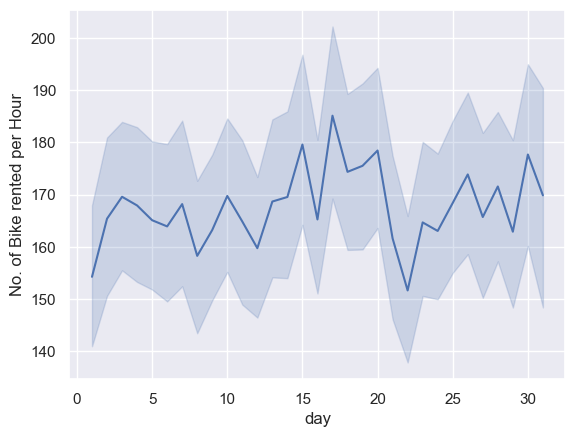

In [43]:
sns.lineplot(x=df_train['day'], y = df_train['count'])
plt.ylabel('No. of Bike rented per Hour')

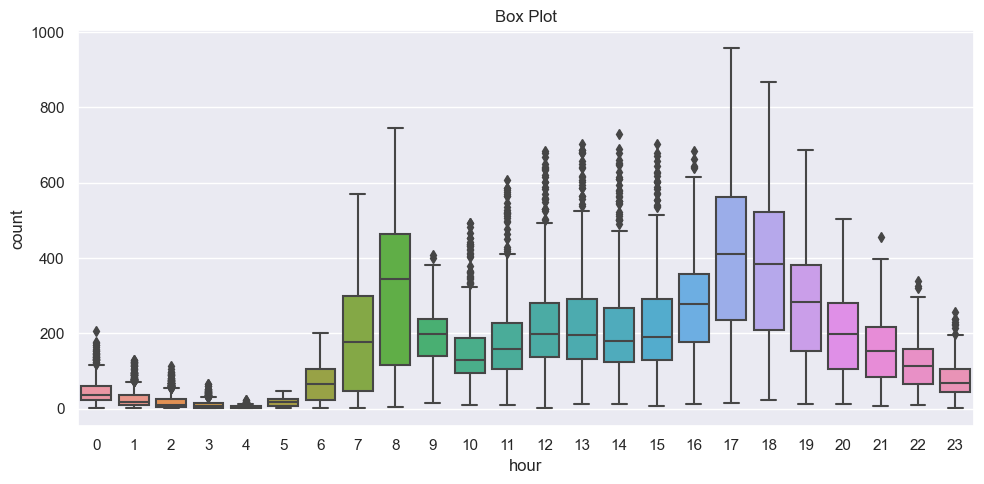

In [44]:
data = df_train['hour']

# figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Plot - 1: Density Plot
# sns.kdeplot(x=df_train['count'], hue=data, ax=axes[0])
# axes[0].set_title('Density Plot')
# axes[0].set_ylabel('Frequency')

# plot - 2: Pie chart
sns.boxplot(x=data, y=df_train['count'])
axes.set_title('Box Plot')

# adjust layout
plt.tight_layout()

# show the plots
plt.show()

Text(0, 0.5, 'No. of Bike rented per Hour')

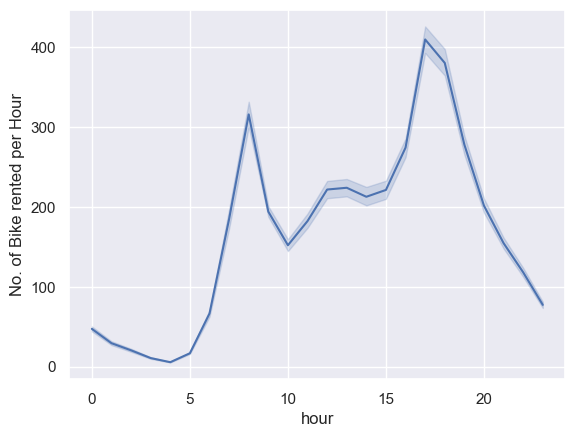

In [45]:
sns.lineplot(x=df_train['hour'], y = df_train['count'])
plt.ylabel('No. of Bike rented per Hour')

### Correlation and pairplot

<Axes: >

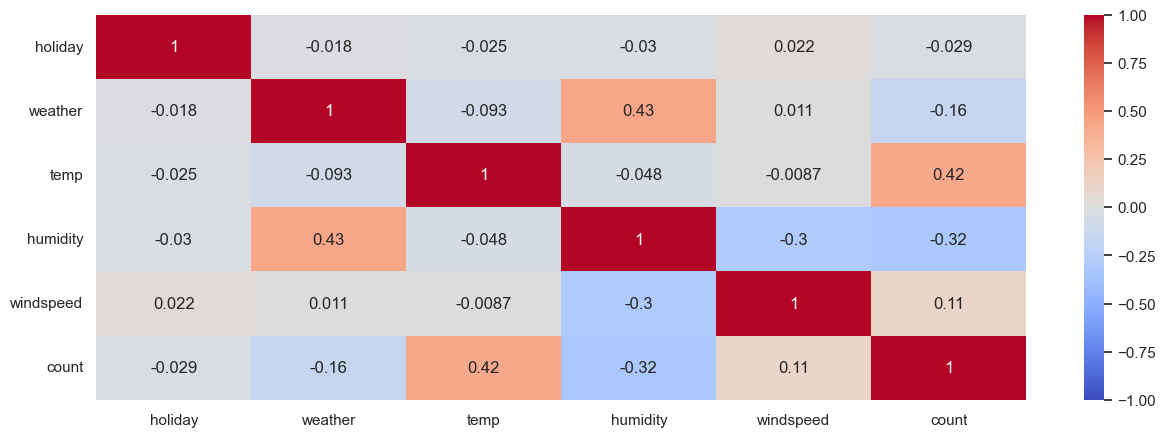

In [46]:
corr = df_train[[
                    'holiday', 
                    'weather', 
                    'temp',
                    'humidity', 
                    'windspeed', 
                    'count'
                ]].corr(numeric_only=True)
plt.figure(figsize=(15,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

As we can see that temp and atemp highly colrrelated between them. These two variable together won't add much information predicting target. So, we will drop atemp because it is a bit less correlated with the target as compare to temp.

In [47]:
df_train.drop('atemp', axis=1, inplace=True)
df_test.drop('atemp', axis=1, inplace=True)
print(df_train.columns.sort_values())
print(df_test.columns.sort_values())

Index(['count', 'datetime', 'day', 'holiday', 'hour', 'humidity', 'month',
       'season', 'temp', 'weather', 'windspeed', 'workingday', 'year'],
      dtype='object')
Index(['datetime', 'day', 'holiday', 'hour', 'humidity', 'month', 'season',
       'temp', 'weather', 'windspeed', 'workingday', 'year'],
      dtype='object')


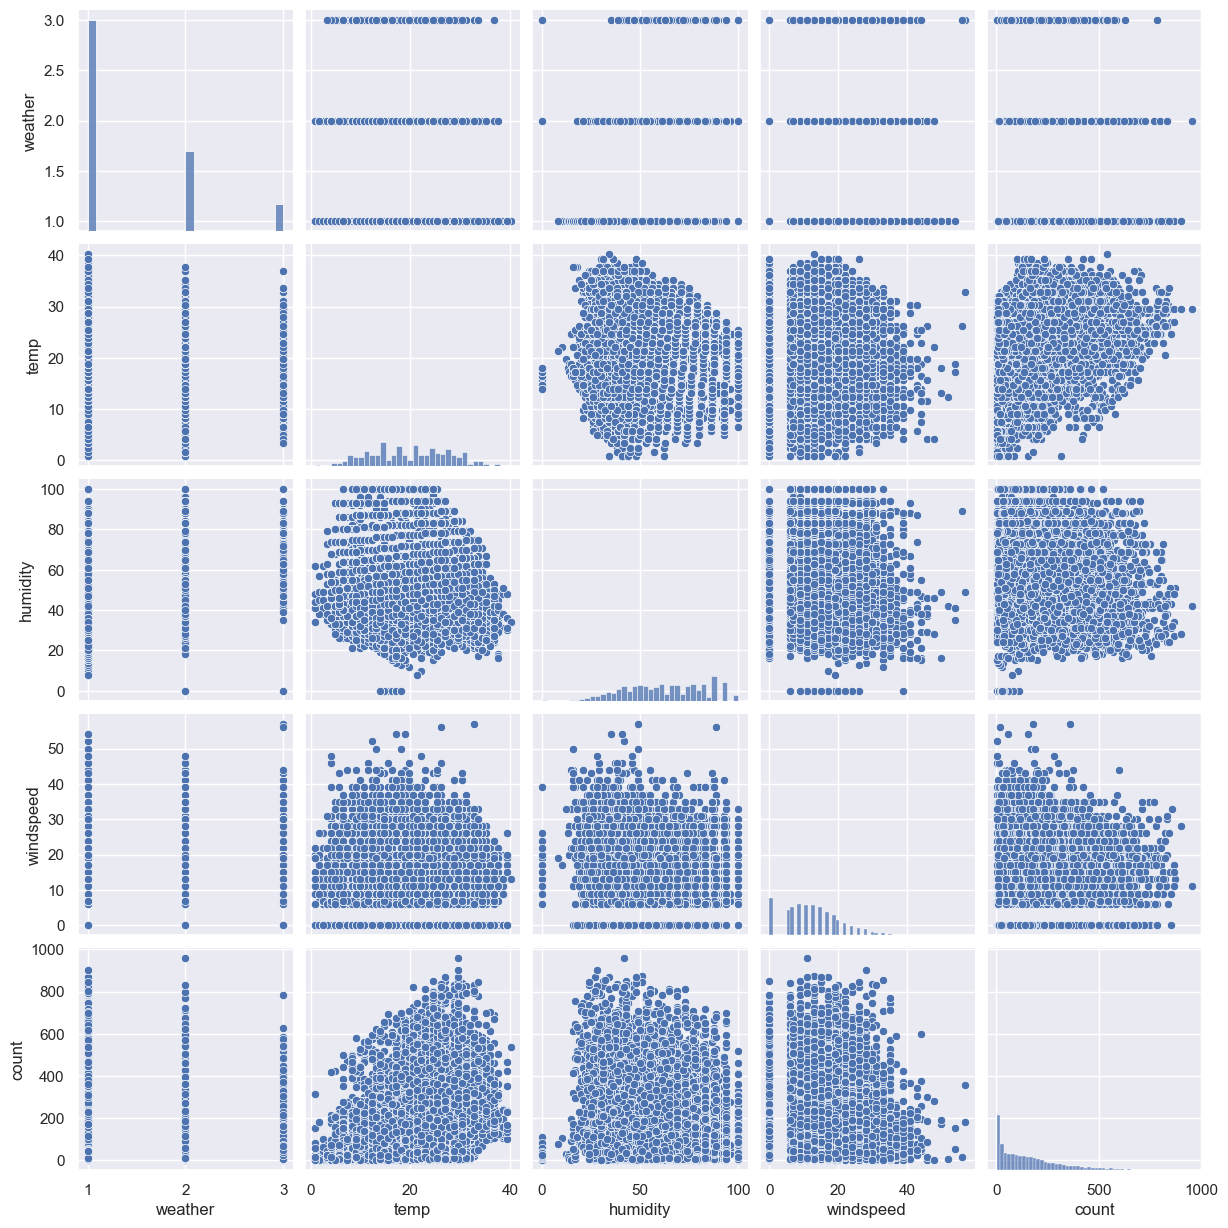

In [48]:
sns.pairplot(df_train[[ 
                        'weather', 
                        'temp',
                        'humidity', 
                        'windspeed', 
                        'count'
                      ]]
            )

## Train-test split

In [49]:
split = pd.to_datetime('2012-03-30')
X_train = df_train.loc[df_train['datetime']<=split, :]
X_validation = df_train.loc[df_train['datetime']>split, :]
X_train.shape, X_validation.shape

((10774, 13), (2206, 13))

In [50]:
X_train.head(3)

,datetime,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,day,hour
0,2011-01-01 00:00:00,spring,0,0,1,9.84,81.0,0.0,16,2011,1,1,0
1,2011-01-01 01:00:00,spring,0,0,1,9.02,80.0,0.0,40,2011,1,1,1
2,2011-01-01 02:00:00,spring,0,0,1,9.02,80.0,0.0,32,2011,1,1,2


Dropping `datetime column`

In [51]:
X_train.drop('datetime', axis=1, inplace=True)
X_validation.drop('datetime', axis=1, inplace=True)
df_test.drop('datetime', axis=1, inplace=True)

In [52]:
X_train.head(3)

,season,holiday,workingday,weather,temp,humidity,windspeed,count,year,month,day,hour
0,spring,0,0,1,9.84,81.0,0.0,16,2011,1,1,0
1,spring,0,0,1,9.02,80.0,0.0,40,2011,1,1,1
2,spring,0,0,1,9.02,80.0,0.0,32,2011,1,1,2


In [53]:
df_test

,season,holiday,workingday,weather,temp,humidity,windspeed,year,month,day,hour
0,fall,0,0,3,26.24,89.0,15.0013,2012,6,30,1
1,fall,0,0,2,26.24,89.0,0.0000,2012,6,30,2
2,fall,0,0,2,26.24,89.0,0.0000,2012,6,30,3
3,fall,0,0,2,25.42,94.0,0.0000,2012,6,30,4
4,fall,0,0,1,26.24,89.0,11.0014,2012,6,30,5
...,...,...,...,...,...,...,...,...,...,...,...
4394,spring,0,1,2,10.66,60.0,11.0014,2012,12,31,19
4395,spring,0,1,2,10.66,60.0,11.0014,2012,12,31,20
4396,spring,0,1,1,10.66,60.0,11.0014,2012,12,31,21
4397,spring,0,1,1,10.66,56.0,8.9981,2012,12,31,22


#### Creating target array

In [54]:
y_train = X_train.pop('count')
y_validation = X_validation.pop('count')
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape

((10774, 11), (10774,), (2206, 11), (2206,))

In [55]:
y_train = y_train.ravel()
y_validation = y_validation.ravel()

In [56]:
y_train

array([ 16,  40,  32, ..., 152,  94,  59], dtype=int64)

In [57]:
y_validation

array([ 27,   7,   7, ..., 163,  48,  69], dtype=int64)

## Encoding categorical variable

In [58]:
X_train = X_train.astype({col:str for col in ['season', 'year']})
X_validation = X_validation.astype({col:str for col in ['season', 'year']})
df_test = df_test.astype({col:str for col in ['season', 'year']})

In [59]:
ohe1 = OneHotEncoder(drop_last_binary=True, variables=['season', 'year'])

In [60]:
X_train_t = ohe1.fit_transform(X_train)
X_validation_t = ohe1.transform(X_validation)
df_test_t = ohe1.transform(df_test)

In [61]:
X_train_t.head(3)

,holiday,workingday,weather,temp,humidity,windspeed,month,day,hour,season_spring,season_summer,season_fall,season_winter,year_2011
0,0,0,1,9.84,81.0,0.0,1,1,0,1,0,0,0,1
1,0,0,1,9.02,80.0,0.0,1,1,1,1,0,0,0,1
2,0,0,1,9.02,80.0,0.0,1,1,2,1,0,0,0,1


In [62]:
print(X_train_t.shape)
X_train_t.describe()

(10774, 14)


,holiday,workingday,weather,temp,humidity,windspeed,month,day,hour,season_spring,season_summer,season_fall,season_winter,year_2011
count,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000,10774.000000
mean,0.028680,0.684147,1.435771,18.895619,63.257565,13.079787,5.665955,15.604604,11.564229,0.369408,0.224615,0.207908,0.198069,0.802395
std,0.166914,0.464876,0.650675,7.995723,19.899330,8.429196,3.593221,8.754241,6.910032,0.482667,0.417348,0.405829,0.398563,0.398211
min,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,12.300000,47.000000,7.001500,2.000000,8.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,1.000000,18.040000,63.000000,12.998000,5.000000,16.000000,12.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,2.000000,25.420000,80.000000,19.001200,9.000000,23.000000,18.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,3.000000,39.360000,100.000000,56.996900,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Defining a function which will return the rmsle score

In [63]:
def rmsle(y, y_):
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

### Defining a function for model evaluation

In [64]:
def model_score(model, X_train, X_val, y_train, y_val):

    # y_train = np.square(y_train_sqrt)
    # y_val = np.square(y_val_sqrt)
    scores = {}

    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    
    # RMSLE of train and validation set
    rmsle_train = rmsle(y_train, pred_train)
    rmsle_val = rmsle(y_val, pred_val)

    # R2 of train and validation set
    r2_train = r2_score(y_train, pred_train)
    r2_val = r2_score(y_val, pred_val)
    
    scores[model.__class__.__name__] = model
    scores['rmsle_train'] = rmsle_train
    scores['rmsle_val'] = rmsle_val
    scores['r2_train'] = r2_train
    scores['r2_val'] = r2_val

    return scores 


## Tree model

### Decision Tree Regressor

In [65]:
# the objective function takes the hyperparameter space
# as input
def objective(trial):

    max_depth = trial.suggest_int("max_depth", 2, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    
    
    model = DecisionTreeRegressor(
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split
                                )
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()


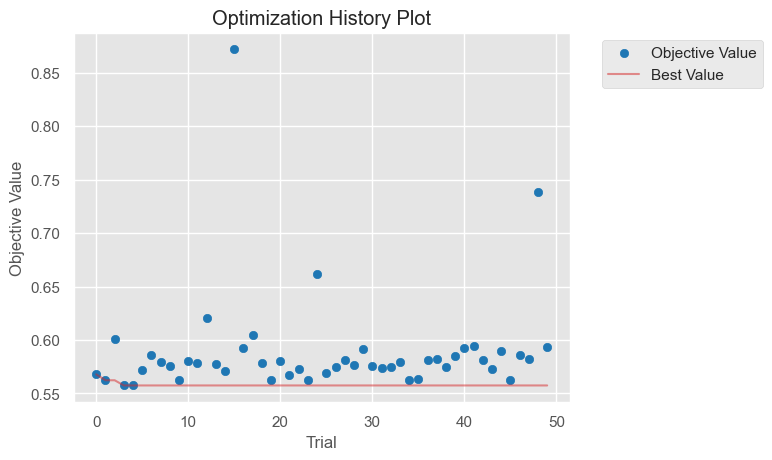

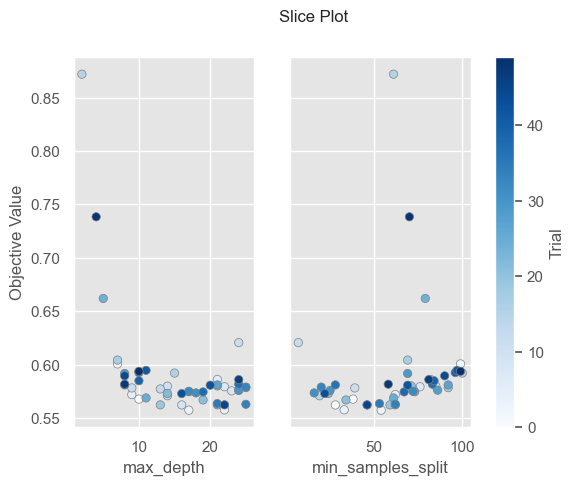

In [66]:
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [67]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_min_samples_split,system_attrs_nsga3:generation,state
0,0,0.567766,2024-01-18 01:01:54.904512,2024-01-18 01:01:57.183963,0 days 00:00:02.279451,10,38,0,COMPLETE
1,1,0.562278,2024-01-18 01:01:54.911307,2024-01-18 01:01:57.118962,0 days 00:00:02.207655,22,28,0,COMPLETE
2,2,0.600696,2024-01-18 01:01:54.914647,2024-01-18 01:01:56.801937,0 days 00:00:01.887290,7,99,0,COMPLETE
3,3,0.557414,2024-01-18 01:01:54.925738,2024-01-18 01:01:56.900738,0 days 00:00:01.975000,17,54,0,COMPLETE
4,4,0.557729,2024-01-18 01:01:54.938739,2024-01-18 01:01:57.063131,0 days 00:00:02.124392,22,33,0,COMPLETE
5,5,0.572046,2024-01-18 01:01:54.945746,2024-01-18 01:01:56.959677,0 days 00:00:02.013931,9,62,0,COMPLETE
6,6,0.586112,2024-01-18 01:01:54.956754,2024-01-18 01:01:56.991137,0 days 00:00:02.034383,21,82,0,COMPLETE
7,7,0.579355,2024-01-18 01:01:54.969751,2024-01-18 01:01:57.176959,0 days 00:00:02.207208,22,76,0,COMPLETE
8,8,0.575498,2024-01-18 01:01:55.080591,2024-01-18 01:01:57.097968,0 days 00:00:02.017377,23,20,0,COMPLETE
9,9,0.562333,2024-01-18 01:01:55.125998,2024-01-18 01:01:57.079128,0 days 00:00:01.953130,16,46,0,COMPLETE


In [68]:
dt = DecisionTreeRegressor()

In [69]:
print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(dt.set_params(**study.best_trial.params), X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'max_depth': 17, 'min_samples_split': 54}
least value from trials 0.5574138746128299


{'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=17, min_samples_split=54),
 'rmsle_train': 0.3721932887616569,
 'rmsle_val': 0.44458503005039285,
 'r2_train': 0.9139039149176148,
 'r2_val': 0.834039055443091}

DecisionTreeRegressor(max_depth=17, min_samples_split=54)


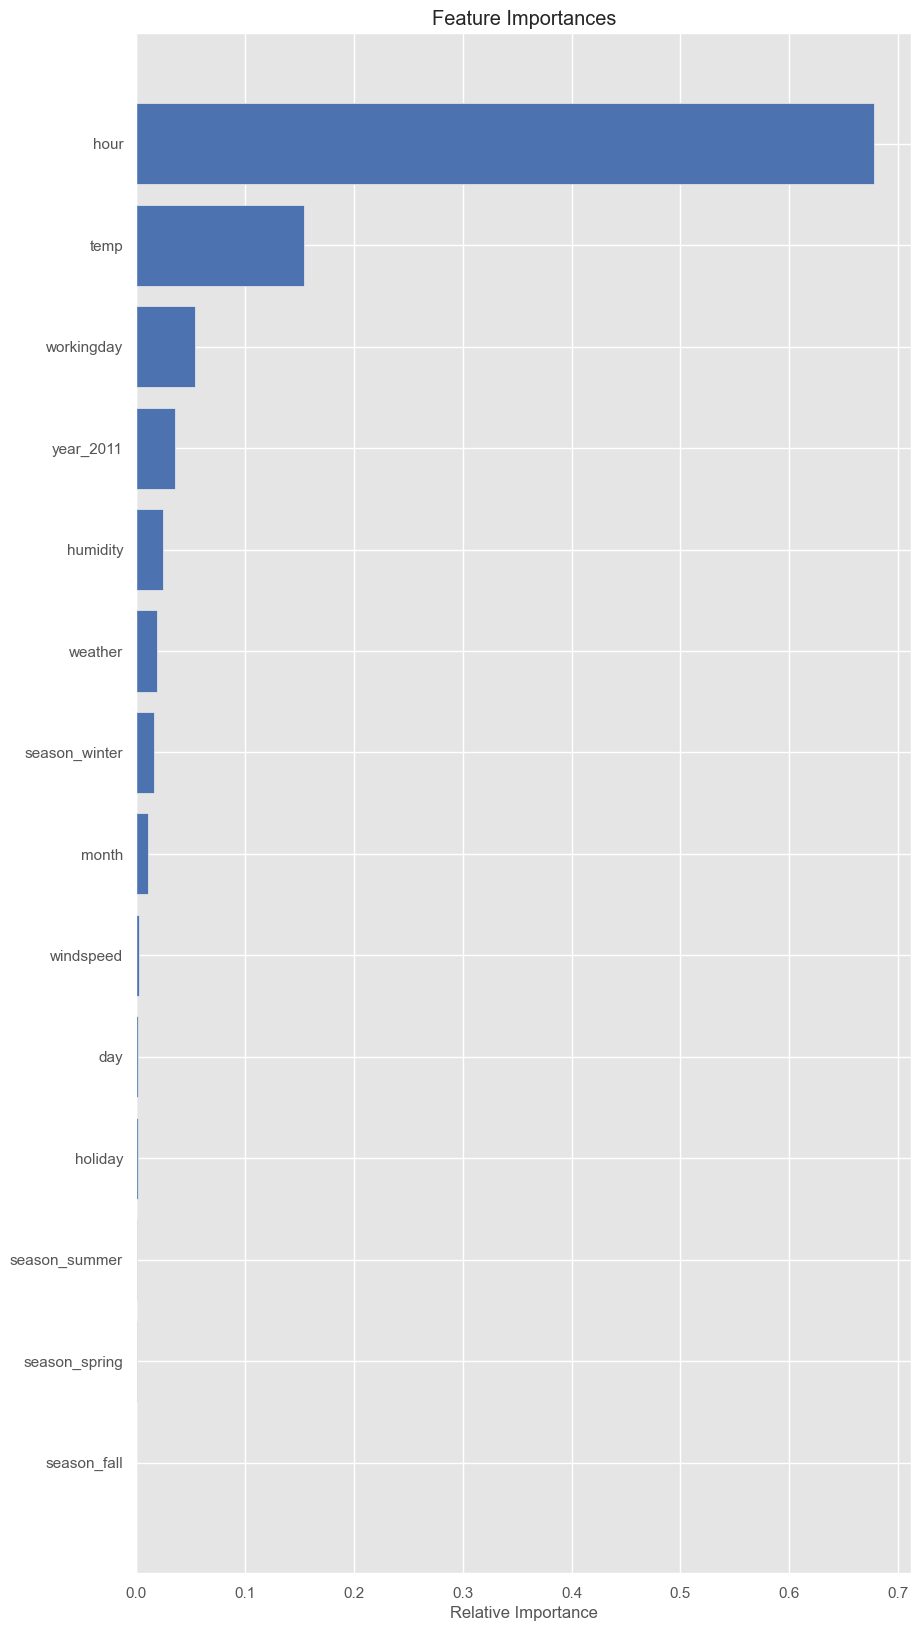

In [70]:
model = scores['DecisionTreeRegressor']
model.fit(X_train_t, y_train)
print(model)
features = X_train_t.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Why is `workingday` the third most important features? Is there a interaction effect with `hour`? Let's see!

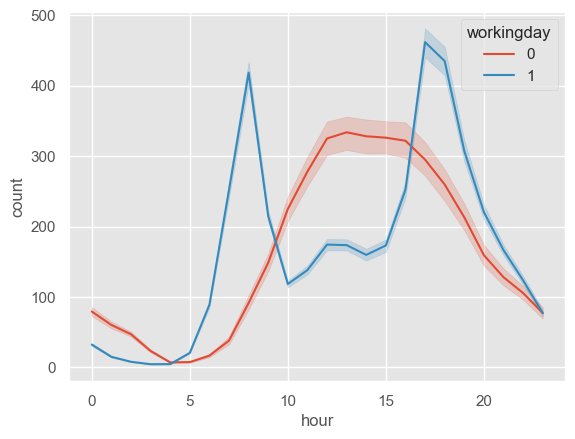

In [74]:
sns.lineplot(data=df_train, x='hour', y='count', hue='workingday')
plt.show()

Comments

As we can see `workingday` has interaction effect with `hour`.
- The demand is highest in the morning and evening on `workingday` and non-workingday the demand is highest in the afternoon.


### submission_1

In [70]:
pred_test = model.predict(df_test_t)
pd.Series(pred_test, name='count_pred').to_csv('dt_submission_1.csv', index=False)

### Random Forest Regressor

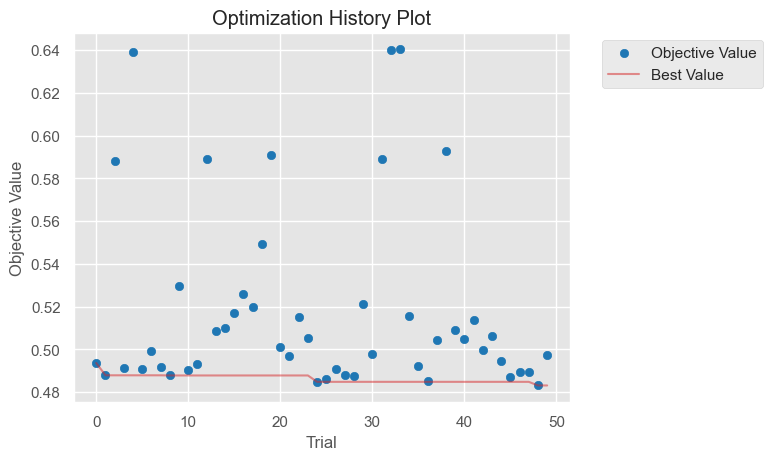

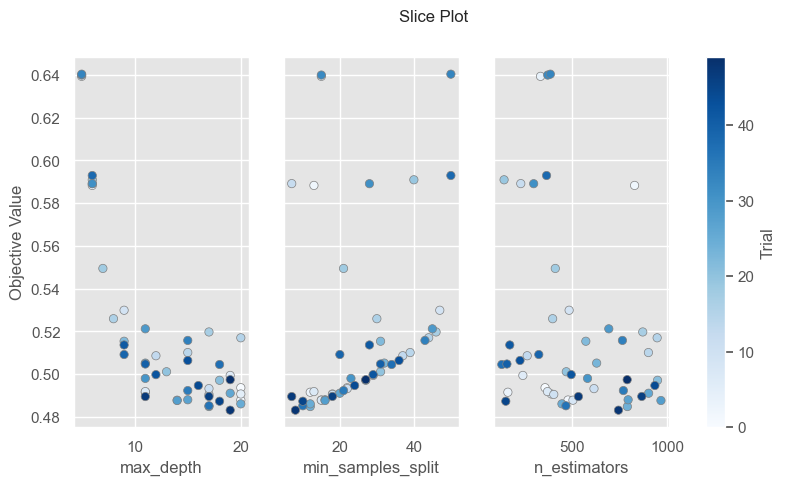

In [76]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    
    
    model = RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    n_jobs=-1,
                                    random_state=42
                                )

    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [77]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

In [78]:
print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(rf.set_params(**study.best_trial.params), X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'n_estimators': 744, 'max_depth': 19, 'min_samples_split': 8}
least value from trials 0.4831780241046516


{'RandomForestRegressor': RandomForestRegressor(max_depth=19, min_samples_split=8, n_estimators=744,
                       n_jobs=-1, random_state=42),
 'rmsle_train': 0.2401702077175013,
 'rmsle_val': 0.38566714381211975,
 'rmsle_cv': 0.4831780241046517,
 'rmsle_cv_std': 0.05872076745422194,
 'r2_train': 0.974908730745823,
 'r2_val': 0.8689122898048883,
 'r2_cv': 0.7642566150443784,
 'r2_cv_std': 0.07404675349936503}

RandomForestRegressor(max_depth=19, min_samples_split=8, n_estimators=744,
                      n_jobs=-1, random_state=42)


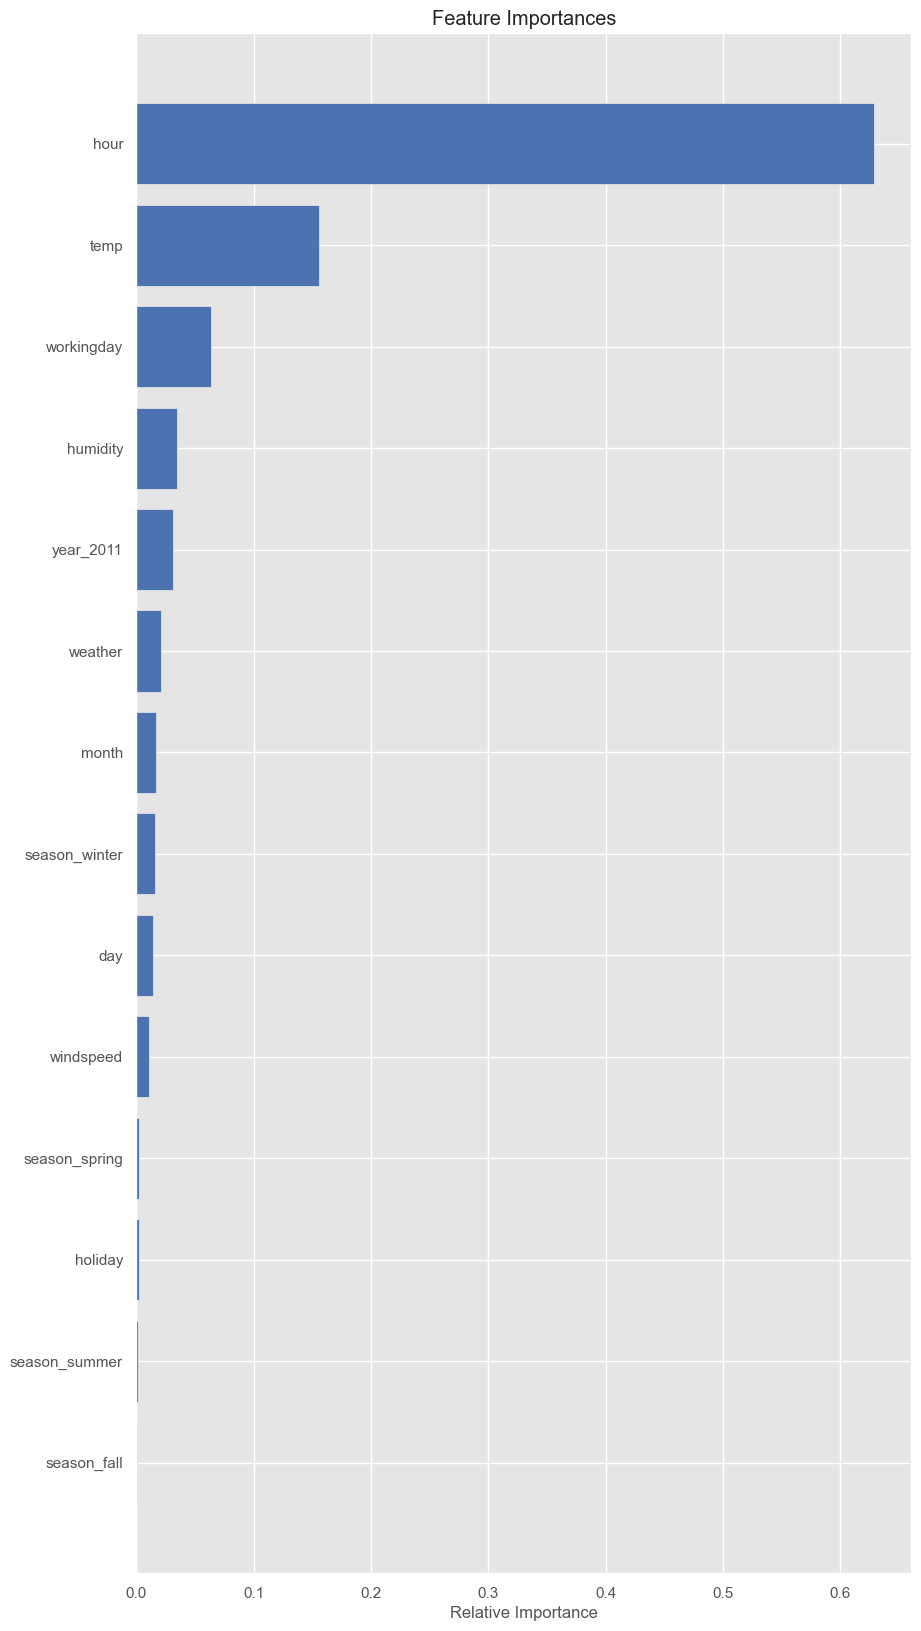

In [79]:
rf.set_params(**study.best_trial.params)
rf.fit(X_train_t, y_train)
print(rf)
features = X_train_t.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## submission - 2

In [80]:
# rf.set_params(**study.best_trial.params)
# rf.fit(X_train_t, y_train_sqrt)
# print(rf)
pred_test = rf.predict(df_test_t)
pred_test

array([ 92.62225943,  65.346823  ,  36.88769966, ..., 133.97111565,
        95.1226551 ,  56.50771741])

In [101]:
pd.Series(pred_test, name='count_pred').to_csv('rf_submission_2.csv', index=False)

### Gradiant Boosting Regressor

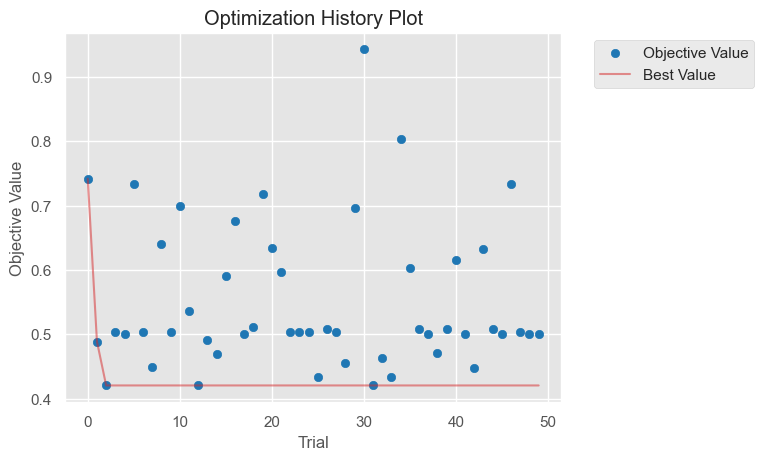

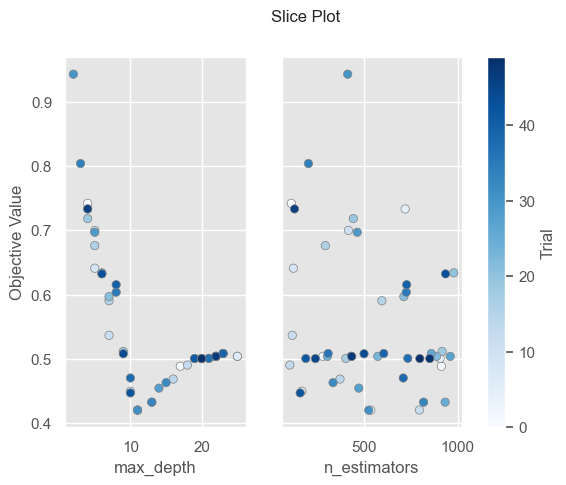

In [71]:
# the objective function takes the hyperparameter space
# as input

def objective(trial):

    max_depth = trial.suggest_int('max_depth', 2, 25)
    # learning_rate = trial.suggest_float('learning_rate', 0.001, 1)
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    # min_samples_split = trial.suggest_int('min_samples_split', 2, 50)
    # loss = trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    # criterion = trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error'])
    
    model = GradientBoostingRegressor(
                                    max_depth=max_depth,
                                    # learning_rate=learning_rate,
                                    n_estimators=n_estimators,
                                    # min_samples_split=min_samples_split,
                                    # loss = 'absolute_error',
                                    # criterion = criterion,
                                    random_state=42
                                )

    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [79]:
gbr = GradientBoostingRegressor(random_state=42)
# gbr = GradientBoostingRegressor(random_state=42)

In [80]:
print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(gbr.set_params(**study.best_trial.params), X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'max_depth': 11, 'n_estimators': 527}
least value from trials 0.4203137211463524


{'GradientBoostingRegressor': GradientBoostingRegressor(max_depth=11, n_estimators=527, random_state=42),
 'rmsle_train': 0.00434889589919887,
 'rmsle_val': 0.4203137211463524,
 'rmsle_cv': 0.5310510507431292,
 'rmsle_cv_std': 0.051906244648463745,
 'r2_train': 0.9999998586109285,
 'r2_val': 0.8570625962952009,
 'r2_cv': 0.7582543219296534,
 'r2_cv_std': 0.06192764945730642}

GradientBoostingRegressor(max_depth=11, n_estimators=527, random_state=42)


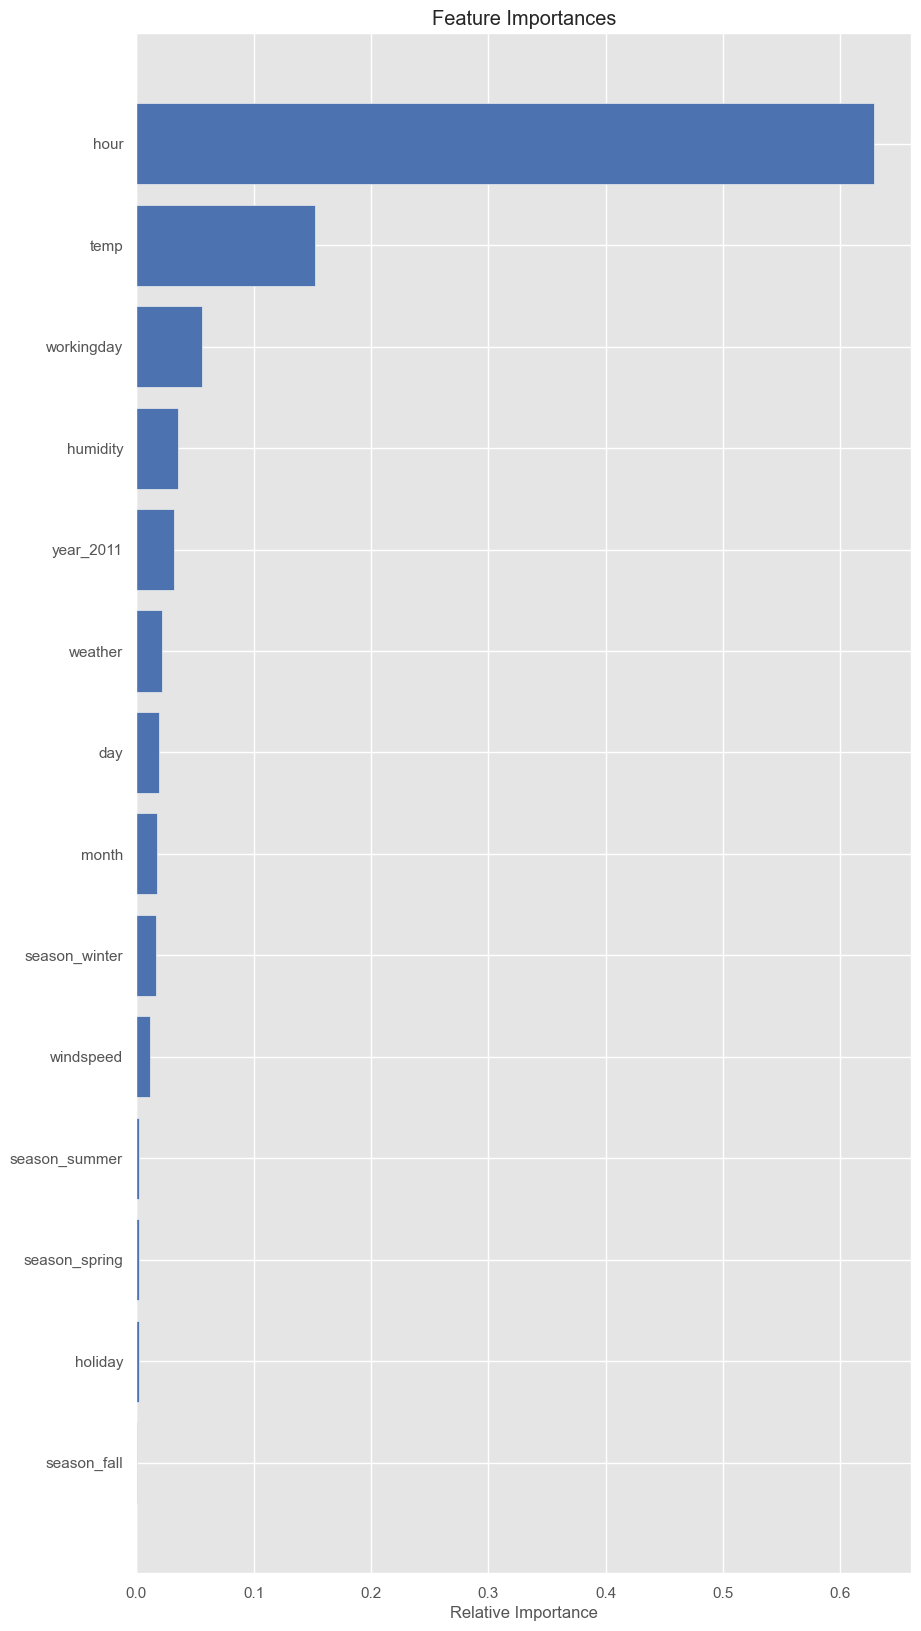

In [85]:
gbr.set_params(**study.best_trial.params)
gbr.fit(X_train_t, y_train)
print(gbr)
features = X_train_t.columns
importances = gbr.feature_importances_
indices = np.argsort(importances)

fig, ax = plt.subplots(figsize=(10, 20))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [76]:
gbr

GradientBoostingRegressor(max_depth=11, n_estimators=527, random_state=42)

<Axes: >

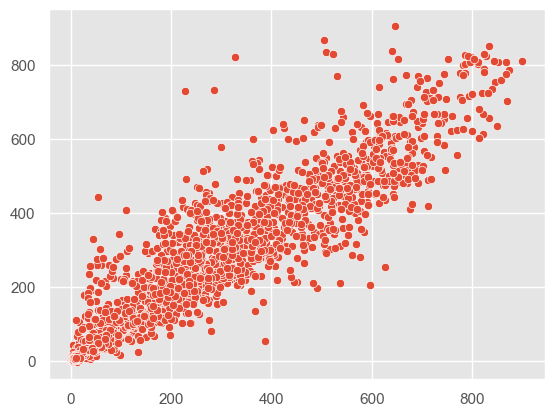

In [86]:
# gbr.fit(X_train_t, y_train)
sns.scatterplot(x=y_validation, y=gbr.predict(X_validation_t))

### Submission - 3

In [87]:
pred_test = gbr.predict(df_test_t)
pred_test

array([103.68621813,  67.07715573,  44.81764435, ..., 143.42309986,
       108.16026826,  56.75610881])

In [88]:
pd.Series(pred_test, name='count_pred').to_csv('gbr_submission_3.csv')

## linear model

In [92]:
X_train_t.head(3)

,holiday,workingday,weather,temp,humidity,windspeed,month,day,hour,season_spring,season_summer,season_fall,season_winter,year_2011
0,0,0,1,9.84,81.0,0.0,1,1,0,1,0,0,0,1
1,0,0,1,9.02,80.0,0.0,1,1,1,1,0,0,0,1
2,0,0,1,9.02,80.0,0.0,1,1,2,1,0,0,0,1


In [102]:
pipe = Pipeline(steps = [('caps', Winsorizer(tail='both', variables=['temp', 'humidity', 'windspeed'])),
                    ('scaling', SklearnTransformerWrapper(transformer=StandardScaler(), variables=['temp', 
                                                                                                   'humidity', 
                                                                                                   'windspeed',
                                                                                                   'weather',
                                                                                                   'month', 
                                                                                                   'day',
                                                                                                   'hour'
                                                                                                   ])),
                    ('ohe', OneHotEncoder(drop_last=True, variables=['season', 'year']))
                    ]
                )

In [103]:
X_train_t = pipe.fit_transform(X_train)
X_validation_t = pipe.transform(X_validation)
df_test_t = pipe.transform(df_test)

In [104]:
X_train_t.describe()

,holiday,workingday,weather,temp,humidity,windspeed,month,day,hour,season_spring,season_summer,season_fall,year_2011
count,10774.000000,10774.000000,1.077400e+04,1.077400e+04,1.077400e+04,1.077400e+04,10774.000000,1.077400e+04,1.077400e+04,10774.000000,10774.000000,10774.000000,10774.000000
mean,0.028680,0.684147,6.660926e-17,-8.441570e-17,4.220785e-17,1.846593e-16,0.000000,-5.275981e-18,-1.081576e-16,0.369408,0.224615,0.207908,0.802395
std,0.166914,0.464876,1.000046e+00,1.000046e+00,1.000046e+00,1.000046e+00,1.000046,1.000046e+00,1.000046e+00,0.482667,0.417348,0.405829,0.398211
min,0.000000,0.000000,-6.697528e-01,-2.260766e+00,-3.003760e+00,-1.568874e+00,-1.298604,-1.668366e+00,-1.673620e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,-6.697528e-01,-8.249316e-01,-8.183188e-01,-7.270404e-01,-1.020289,-8.687168e-01,-8.052766e-01,0.000000,0.000000,0.000000,1.000000
50%,0.000000,1.000000,-6.697528e-01,-1.070146e-01,-1.332460e-02,-6.044097e-03,-0.185345,4.516835e-02,6.306650e-02,0.000000,0.000000,0.000000,1.000000
75%,0.000000,1.000000,8.671836e-01,8.160217e-01,8.419818e-01,7.157578e-01,0.927914,8.448179e-01,9.314096e-01,1.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,2.404120e+00,2.559535e+00,1.848225e+00,3.044132e+00,1.762858,1.758703e+00,1.655029e+00,1.000000,1.000000,1.000000,1.000000


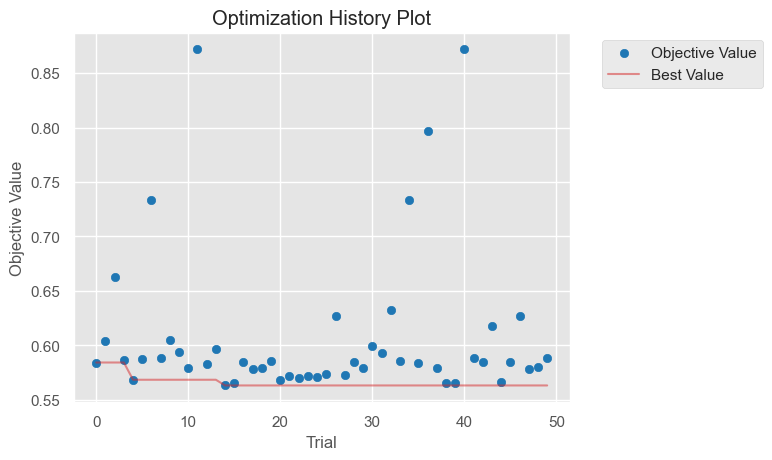

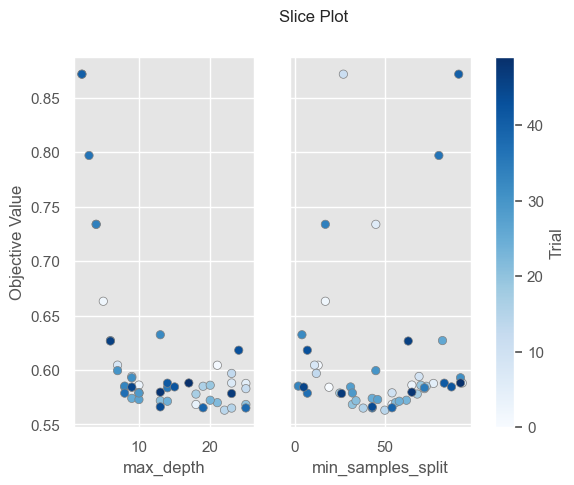

In [107]:
# the objective function takes the hyperparameter space
# as input
def objective(trial):

    max_depth = trial.suggest_int("max_depth", 2, 25)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)
    
    
    model = DecisionTreeRegressor(
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split
                                )
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [109]:
print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(dt.set_params(**study.best_trial.params), X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'max_depth': 22, 'min_samples_split': 50}
least value from trials 0.5631431805108179


{'DecisionTreeRegressor': DecisionTreeRegressor(max_depth=22, min_samples_split=50),
 'rmsle_train': 0.3734052139898919,
 'rmsle_val': 0.443008556103469,
 'rmsle_cv': 0.5629032489843414,
 'rmsle_cv_std': 0.06942696130948611,
 'r2_train': 0.9123786092221069,
 'r2_val': 0.8340456036918719,
 'r2_cv': 0.6735855769120979,
 'r2_cv_std': 0.08757969427626922}

In [ ]:
# the objective function takes the hyperparameter space
# as input
def objective(trial):

    max_depth = trial.suggest_int("max_depth", 2, 25)
    
    model = DecisionTreeRegressor(
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split
                                )
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [127]:
# the objective function takes the hyperparameter space
# as input


    
model = TransformedTargetRegressor(regressor=LinearRegression(), func=np.sqrt, inverse_func=np.square)
model.fit(X_train_t, y_train)
model.score(X_train_t, y_train), model.score(X_validation_t, y_validation)


(0.3500436234046095, 0.3377380777987121)

In [128]:
scores = model_score(model, X_train_t, X_validation_t, y_train, y_validation)
scores

{'TransformedTargetRegressor': TransformedTargetRegressor(func=<ufunc 'sqrt'>, inverse_func=<ufunc 'square'>,
                            regressor=LinearRegression()),
 'rmsle_train': 1.049970954350053,
 'rmsle_val': 1.1848689207519958,
 'rmsle_cv': 9.075807583211242,
 'rmsle_cv_std': 17.768569257863646,
 'r2_train': 0.3500436234046095,
 'r2_val': 0.3377380777987121,
 'r2_cv': -4.979216610096912e+47,
 'r2_cv_std': 1.1133866814872763e+48}

In [120]:
pd.Series(model.predict(X_validation_t)).describe()

count    2206.000000
mean      243.894309
std       114.218971
min        45.095962
25%       138.672196
50%       235.972130
75%       343.970616
max       525.679359
dtype: float64

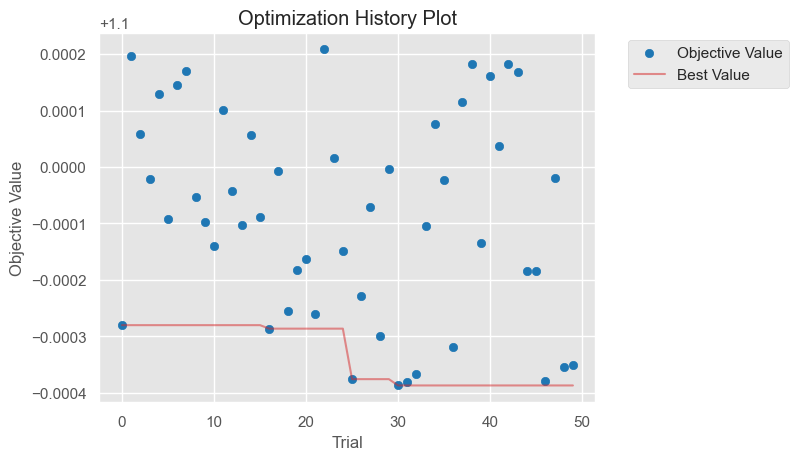

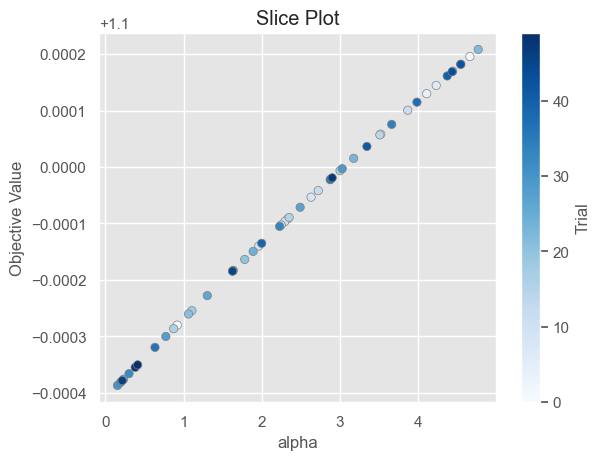

In [133]:
# the objective function takes the hyperparameter space
# as input
def objective(trial):

    alpha = trial.suggest_float("alpha", 0.0001, 5)
    
    reg = Ridge(alpha=alpha)
    model = TransformedTargetRegressor(regressor=reg, func=np.sqrt, inverse_func=np.square)
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [134]:
study.best_trial.params

{'alpha': 0.155101501824337}

In [135]:
reg = Ridge(alpha=study.best_trial.params['alpha'])
model = TransformedTargetRegressor(regressor=reg, func=np.sqrt, inverse_func=np.square)

print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(model, X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'alpha': 0.155101501824337}
least value from trials 1.0996129852753733


{'TransformedTargetRegressor': TransformedTargetRegressor(func=<ufunc 'sqrt'>, inverse_func=<ufunc 'square'>,
                            regressor=Ridge(alpha=0.155101501824337)),
 'rmsle_train': 1.0499696576781887,
 'rmsle_val': 1.1848566910292673,
 'rmsle_cv': 1.0996129852753733,
 'rmsle_cv_std': 0.07872471149099448,
 'r2_train': 0.3500386131086207,
 'r2_val': 0.33772672474494614,
 'r2_cv': 0.18754415902729332,
 'r2_cv_std': 0.07708385688535253}

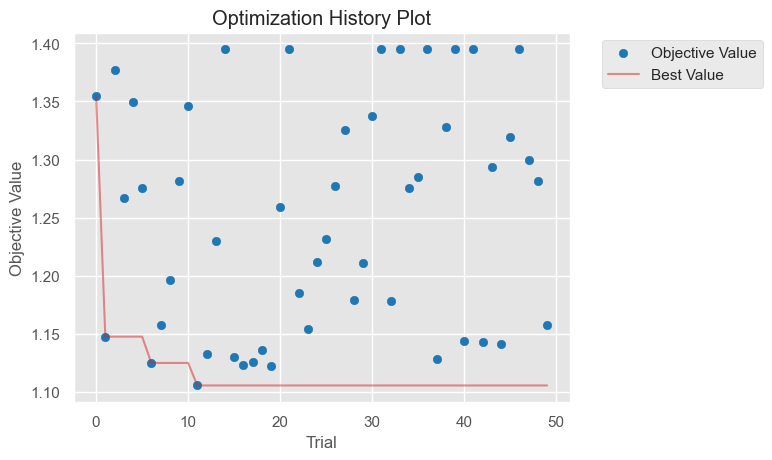

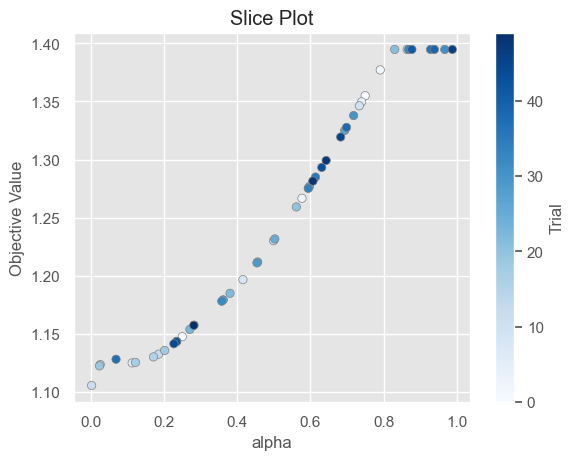

In [139]:
# the objective function takes the hyperparameter space
# as input
def objective(trial):

    alpha = trial.suggest_float("alpha", 0.0001, 1)
    
    reg = Lasso(alpha=alpha)
    model = TransformedTargetRegressor(regressor=reg, func=np.log, inverse_func=np.exp)
    
    tscv = TimeSeriesSplit(n_splits=5, test_size=1000)
    scores = []
    for train_idx, val_idx in tscv.split(X_train_t):
    
        model.fit(X_train_t.iloc[train_idx], y_train[train_idx])
        val_pred = model.predict(X_train_t.iloc[val_idx, :])
        score = rmsle(y_train[val_idx], val_pred)
        scores.append(score)

    return np.array(scores).mean()


study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.NSGAIIISampler()
)

study.optimize(objective, n_trials=50, n_jobs=-1)
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

In [140]:
reg = Lasso(alpha=study.best_trial.params['alpha'])
model = TransformedTargetRegressor(regressor=reg, func=np.log, inverse_func=np.exp)

print(f'best params from trials: {study.best_trial.params}')
print(f'least value from trials {study.best_trial.value}')
scores = model_score(model, X_train_t, X_validation_t, y_train, y_validation)
scores

best params from trials: {'alpha': 0.0027637736762220005}
least value from trials 1.1058864993295758


{'TransformedTargetRegressor': TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                            regressor=Lasso(alpha=0.0027637736762220005)),
 'rmsle_train': 1.0107041593320927,
 'rmsle_val': 1.067864203834666,
 'rmsle_cv': 1.1058864993295758,
 'rmsle_cv_std': 0.07792755140929965,
 'r2_train': 0.18228867331544896,
 'r2_val': -0.11692294702745842,
 'r2_cv': -0.027397463297666326,
 'r2_cv_std': 0.11734614081670205}

### Scaling target

In [151]:
target_scaling = StandardScaler()
y_train_scaled = target_scaling.fit_transform(y_train.reshape(-1,1))
y_validation_scaled = target_scaling.transform(y_validation.reshape(-1, 1))

In [154]:
y_train_scaled = y_train_scaled.ravel()
y_validation_scaled = y_validation_scaled.ravel()
y_train_scaled

array([-0.95079563, -0.7781267 , -0.83568301, ...,  0.02766165,
       -0.3896216 , -0.64143046])

In [159]:
y_train

array([ 16,  40,  32, ..., 152,  94,  59], dtype=int64)

In [171]:
y_validation

array([ 27,   7,   7, ..., 163,  48,  69], dtype=int64)

In [163]:
X_train_t.shape

(10774, 13)

In [178]:
# model = Sequential()
# model.add(Dense(128, input_dim=13, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# # output layer
# model.add(Dense(1, activation='linear'))

In [189]:
model = Sequential()
model.add(Dense(128, input_dim=13, activation='relu'))
model.add(Dense(64, activation='relu'))
# output layer
model.add(Dense(1, activation='linear'))

In [195]:
model.compile(loss='mean_squared_logarithmic_error', 
              optimizer='adam', 
              metrics='r2'
            )

In [191]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 128)               1792      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 10113 (39.50 KB)
Trainable params: 10113 (39.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [192]:
history = model.fit(X_train_t, y_train, 
                    validation_data=(X_validation_t, y_validation), 
                    epochs=100)

Epoch 1/100
337/337 [==============================] - 6s 7ms/step - loss: 3.8067 - mse: 31401.3945 - val_loss: 2.0113 - val_mse: 78231.1016
Epoch 2/100
337/337 [==============================] - 2s 5ms/step - loss: 1.2037 - mse: 19022.1543 - val_loss: 1.3600 - val_mse: 60045.8086
Epoch 3/100
337/337 [==============================] - 2s 5ms/step - loss: 1.0333 - mse: 16342.9678 - val_loss: 1.1524 - val_mse: 52822.3359
Epoch 4/100
337/337 [==============================] - 2s 5ms/step - loss: 0.9394 - mse: 15645.7949 - val_loss: 1.0480 - val_mse: 49778.8281
Epoch 5/100
337/337 [==============================] - 2s 5ms/step - loss: 0.8629 - mse: 15411.0771 - val_loss: 0.9360 - val_mse: 46518.5273
Epoch 6/100
337/337 [==============================] - 2s 5ms/step - loss: 0.7921 - mse: 15229.4189 - val_loss: 0.8690 - val_mse: 45732.4414
Epoch 7/100
337/337 [==============================] - 2s 5ms/step - loss: 0.7186 - mse: 14919.8516 - val_loss: 0.8069 - val_mse: 43885.8359
Epoch 8/100
3

In [198]:
history.history['val_loss']

[2.011298418045044,
 1.3600170612335205,
 1.1524232625961304,
 1.0480118989944458,
 0.9360116124153137,
 0.8690317273139954,
 0.8069372773170471,
 0.7388296723365784,
 0.6808640956878662,
 0.5636630654335022,
 0.5655385851860046,
 0.4659655690193176,
 0.47403526306152344,
 0.48543107509613037,
 0.4043421745300293,
 0.407488614320755,
 0.3792029321193695,
 0.3739140033721924,
 0.3993794918060303,
 0.350143700838089,
 0.3583466708660126,
 0.3518754243850708,
 0.37171173095703125,
 0.36843886971473694,
 0.35018494725227356,
 0.3711272180080414,
 0.35861849784851074,
 0.3794642984867096,
 0.37483906745910645,
 0.3381504416465759,
 0.3453627824783325,
 0.3651612401008606,
 0.3591662347316742,
 0.32289016246795654,
 0.3357589542865753,
 0.33748531341552734,
 0.3788813054561615,
 0.3317047655582428,
 0.3269225060939789,
 0.3521643877029419,
 0.3574889004230499,
 0.3200404644012451,
 0.33191704750061035,
 0.31058552861213684,
 0.3328433334827423,
 0.31527188420295715,
 0.32001110911369324,
 0.

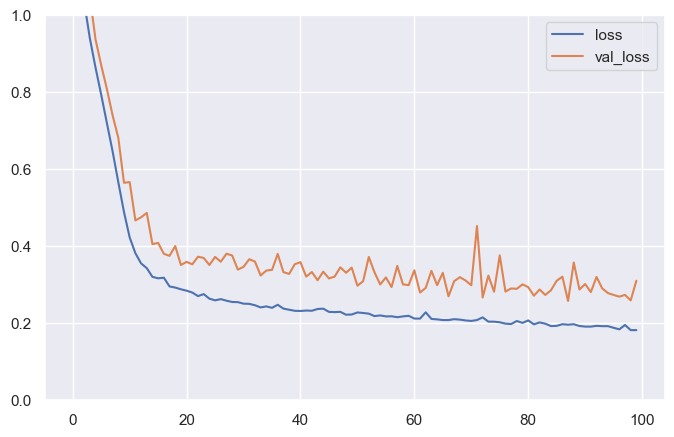

In [199]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [200]:
y_validation

array([ 27,   7,   7, ..., 163,  48,  69], dtype=int64)

In [201]:
print(y_validation)
model.predict(X_validation_t)

69/69 [==============================] - 1s 3ms/step


array([[ 20.619389 ],
       [ 10.120796 ],
       [  5.9545975],
       ...,
       [235.04666  ],
       [217.76744  ],
       [126.61769  ]], dtype=float32)

In [203]:
pred = model.predict(df_test_t)
pred

 33/138 [======>.......................] - ETA: 0s

138/138 [==============================] - 1s 4ms/step


array([[101.79845 ],
       [ 97.66493 ],
       [ 79.263054],
       ...,
       [119.47031 ],
       [ 93.74138 ],
       [ 70.96445 ]], dtype=float32)

In [208]:
pd.Series(pred.ravel(), name='pred_count').to_csv('neural_network_1.csv')

In [229]:
model = Sequential()
model.add(Dense(128, input_dim=13, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(1, activation='linear'))

In [230]:
model.compile(loss='mean_squared_logarithmic_error', 
              optimizer='adam', 
              metrics='mae'
            )

In [231]:
model_history = model.fit(X_train_t, y_train, 
                    validation_data=(X_validation_t, y_validation), 
                    epochs=150)

Epoch 1/150


337/337 [==============================] - 11s 7ms/step - loss: 3.8367 - mae: 121.9322 - val_loss: 1.9965 - val_mae: 203.4884
Epoch 2/150
337/337 [==============================] - 2s 6ms/step - loss: 1.2409 - mae: 91.1164 - val_loss: 1.3619 - val_mae: 172.9276
Epoch 3/150
337/337 [==============================] - 2s 5ms/step - loss: 1.0645 - mae: 85.2462 - val_loss: 1.1652 - val_mae: 160.2889
Epoch 4/150
337/337 [==============================] - 2s 6ms/step - loss: 0.9744 - mae: 84.4399 - val_loss: 1.0775 - val_mae: 155.2825
Epoch 5/150
337/337 [==============================] - 2s 5ms/step - loss: 0.9158 - mae: 84.3471 - val_loss: 0.9783 - val_mae: 149.2344
Epoch 6/150
337/337 [==============================] - 2s 5ms/step - loss: 0.8626 - mae: 83.9721 - val_loss: 0.9283 - val_mae: 147.2901
Epoch 7/150
337/337 [==============================] - 2s 5ms/step - loss: 0.8217 - mae: 83.5184 - val_loss: 0.8809 - val_mae: 142.9398
Epoch 8/150
337/337 [==============================] - 2s 

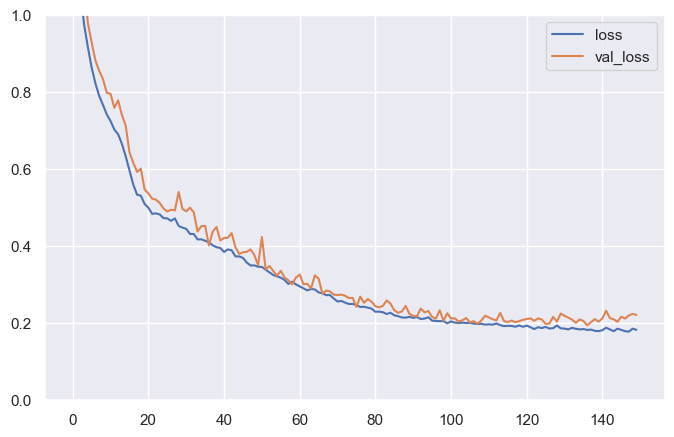

In [232]:
pd.DataFrame(model_history.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [233]:
print(y_validation)
model.predict(X_validation_t)

[ 27   7   7 ... 163  48  69]


69/69 [==============================] - 0s 4ms/step


array([[ 19.058249],
       [  7.480816],
       [  4.477398],
       ...,
       [153.85495 ],
       [139.26648 ],
       [ 74.03157 ]], dtype=float32)

In [234]:
pred = model.predict(df_test_t)
pred

 89/138 [==================>...........] - ETA: 0s

138/138 [==============================] - 1s 4ms/step


array([[ 56.452545],
       [ 65.1231  ],
       [ 47.92688 ],
       ...,
       [109.92651 ],
       [ 91.558495],
       [ 76.699554]], dtype=float32)

In [235]:
pd.Series(pred.ravel(), name='pred_count').describe()

count    4399.000000
mean      222.562317
std       159.793060
min         2.173812
25%        79.931881
50%       196.974457
75%       340.042999
max       757.820496
Name: pred_count, dtype: float64

In [236]:
pd.Series(pred.ravel(), name='pred_count').to_csv('neural_network_3.csv')

In [237]:
model = Sequential()
model.add(Dense(128, input_dim=13, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(1, activation='linear'))

In [238]:
model.compile(loss='mean_squared_logarithmic_error', 
              optimizer='adam', 
              metrics='mae'
            )

In [239]:
model_history = model.fit(X_train_t, y_train, 
                    validation_data=(X_validation_t, y_validation), 
                    epochs=100)

Epoch 1/100
337/337 [==============================] - 5s 7ms/step - loss: 3.2381 - mae: 111.3597 - val_loss: 1.4412 - val_mae: 176.7166
Epoch 2/100
337/337 [==============================] - 2s 6ms/step - loss: 1.0691 - mae: 85.4608 - val_loss: 1.1155 - val_mae: 154.0080
Epoch 3/100
337/337 [==============================] - 2s 6ms/step - loss: 0.9464 - mae: 84.4145 - val_loss: 0.9599 - val_mae: 145.6077
Epoch 4/100
337/337 [==============================] - 2s 6ms/step - loss: 0.8475 - mae: 83.8207 - val_loss: 0.8685 - val_mae: 142.5545
Epoch 5/100
337/337 [==============================] - 2s 6ms/step - loss: 0.7596 - mae: 82.3496 - val_loss: 0.7301 - val_mae: 135.4703
Epoch 6/100
337/337 [==============================] - 2s 6ms/step - loss: 0.6735 - mae: 79.7502 - val_loss: 0.6379 - val_mae: 130.4543
Epoch 7/100
337/337 [==============================] - 2s 6ms/step - loss: 0.5857 - mae: 75.2675 - val_loss: 0.5168 - val_mae: 120.2188
Epoch 8/100
337/337 [==========================

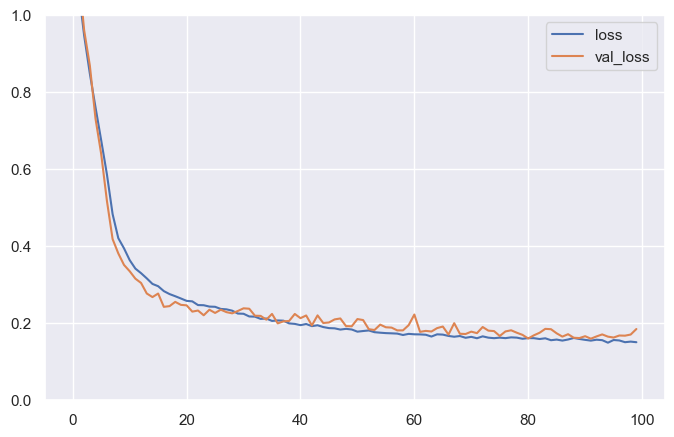

In [240]:
pd.DataFrame(model_history.history)[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

In [241]:
print(y_validation)
model.predict(X_validation_t)

[ 27   7   7 ... 163  48  69]
69/69 [==============================] - 0s 3ms/step


array([[ 11.6056   ],
       [  4.226656 ],
       [  3.1768532],
       ...,
       [118.234314 ],
       [107.33693  ],
       [ 94.06928  ]], dtype=float32)

In [242]:
pred = model.predict(df_test_t)
pred

138/138 [==============================] - 1s 4ms/step


array([[ 79.3221 ],
       [ 84.70127],
       [ 63.24023],
       ...,
       [142.17441],
       [ 96.61495],
       [ 72.66995]], dtype=float32)

In [243]:
pd.Series(pred.ravel(), name='pred_count').describe()

count    4399.000000
mean      196.462128
std       148.656845
min         2.443707
25%        63.738852
50%       168.051346
75%       308.087082
max       608.034790
Name: pred_count, dtype: float64

In [246]:
pd.Series(pred.ravel(), name='pred_count').to_csv('neural_network_4.csv')

In [245]:
r2_score(y_train, model.predict(X_train_t)) ,r2_score(y_validation, model.predict(X_validation_t))

 23/337 [=>............................] - ETA: 1s

69/69 [==============================] - 0s 3ms/step


(0.8862258784274255, 0.8223862602609721)